##### Candidate Number: 1047951
# TABLE OF CONTENTS

# 1. Initial pre-processing
## 1.1. Getting country mapping
## 1.2. Mapping the Dictatorships
## 1.3. Body preprocessing
# 2. Initial exploration of the data (no subsampling)
## 2.1. Embeddings
## 2.2. Similarity of topics: Cosine similarity
## 2.3. Nearest country neighbors of all countries
## 2.4. Similarity of topics: Jaccard Similarity
# 3. Sampling
## 3.1. Extracting the full dataset
## 3.2. Subsample the top 10 values for each regime
## 3.3. Subsample different number of countries for each regime
## 3.4. Calculating the Gini Coefficient
## 3.5. Calculating the trade-off between sample size and representation
## 3.6. Plotting Gini Coeff trade-off
## 3.7. Saving data subsample
# 4. Analysis of the data
## 4.1. Dataset without subsampling
## 4.2. Dataset with subsampling
### 4.1.1. Frequencies
### 4.1.2. Extracting train-test post data
### 4.1.3. Rank-frequency plots
### 4.1.4. Calculating post-level embeddings
### 4.1.5. T-SNE plots
#### 4.1.5.1. Plotting T-SNE for reddit comments
#### 4.1.5.2. Plotting T-SNE for countries
#### 4.1.5.3. Combining the two T-SNE plots
### 4.2.6. Nearest neighbor analysis
# 5. Naive Bayes
## 5.1. Set-up and tuning
## 5.2. Naive Bayes between categories - unigrams
## 5.3. Naive Bayes between categories - bigrams
## 5.4. Naive Bayes between countries
# 6. Relationship between country classification and the variation in yearly frequency occurences
## 6.1. Get Naive Bayes for each country classification
## 6.2. Average prediction accuracy
## 6.3. Normalized Standard deviation
## 6.4. Develop the plost
# 7. Mutual information
## 7.1. For each regime
## 7.2. For each country within the regime
### 7.2.1. Extracting MI
### 7.2.2. Plotting MI
# 8. LSTM Classifier
## 8.1. Build the classifier
## 8.2. Running the model
## 8.3. Import results from Google Colab
# 9. Topic modelling using clustering of embeddings
## 9.1. Cleaning data for topic modelling
### 9.1.1. Removing masks and numbers
### 9.1.2. Removing words that appear in less than 5 documents
### 9.1.3. Extracting the year and regime specific data
## 9.2. Building the topic modelling mechanism
## 9.3. Calculating the best cluster value
## 9.4. Topics through time
## 9.5. Exporting to Latex
# 10. Other
## 10.1. Calculate what percentage of countries have changed rankings
## 10.2. Appearances of each country each month
## 10.3. Get example countries that changed the regime type

# 1. Initial pre-processing

In [1]:
import pandas as pd
import os
import numpy as np
import pycountry
from html import unescape
import operator
import re
import nltk
import pickle
from collections import Counter, defaultdict
from scipy.spatial.distance import cosine
import glob
from matplotlib import gridspec
import json
from itertools import chain
from sklearn.metrics import mutual_info_score

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D   
import seaborn as sns
import ast

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.manifold import TSNE
import numpy as np
import random
import torch
import fasttext.util

from sklearn.cluster import KMeans
from collections import OrderedDict
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score


## 1.1. Getting country mapping

In [ ]:
def number_to_regime(number):
    """Map The Economist Intelligence Unit number to a regime type"""
    if number > 8:
        return 'Full democracy'
    elif number > 6:
        return 'Flawed democracy'
    elif number > 4:
        return 'Hybrid regime'
    elif number >= 0:
        return 'Authoritarian regime'
    else:
        raise ValueError('Data falls outside of the given value range')

In [3]:
# Get additional countries
countries_additional = ['South Korea', 'North Korea', 'Korea', 'UAE', 'Bonaire', 'Bosnia', "Cote D'ivoire", 'Falkland Islands', 'Micronesia', 
                        'Iran', 'Laos', 'Moldova', 'Palestine', 'Syria', 'Taiwan', 'Tanzania', 'USA', 'United States of America', 'US', 'Vatican', 'Vietnam', 'Russia', 'America']
country_list = [c.name for c in pycountry.countries]
countries_all = countries_additional + country_list

In [4]:
# Read democracy file
democracies = pd.read_excel('democracy-dictatorship.xlsx')

# Get deficient mapping countries
deficient_mapping = ['Switzerland', 'Nepal']

# Map the democracies
democracies['Country'] = [x[2:] if x in deficient_mapping else x[1:] for x in democracies.Country.unique()]

In [5]:
def get_countries(text, countries_additional=countries_additional):
    countries = []
    country_list = [c.name for c in pycountry.countries]
    for country in country_list + countries_additional:
        if country in text:
            countries.append(country)
    return countries

In [ ]:
df = pd.read_csv(f".{os.sep}data{os.sep}politics_2010-01.bz2")

In [843]:
df['countries'] = df.body.map(get_countries)
df_countries = df.loc[df.countries.map(lambda x: x != [])].copy()

## 1.2. Mapping the Dictatorships

In [846]:
# Get mapping to the countries
mapping = {'UAE': 'United Arab Emirates',
           'Bosnia': 'Bosnia and Herzegovina',
           'USA': 'United States',
           'United States of America': 'United States',
           'US': 'United States',
           'America': 'United States',
           'Congo, The Democratic Republic of the': 'Democratic Republic of the Congo',
           'Congo': 'Democratic Republic of the Congo',
           'Czechia': 'Czech Republic',
           'Dominica': 'Dominican Republic',
            'Iran, Islamic Republic of': 'Iran',
           'Russian Federation': 'Russia',
           'Viet nam': 'Vietnam',
           'Syrian Arab Republic': 'Syria',
           'England': 'United Kingdom',
           'UK': 'United Kingdom',
           'Great Britain': 'United Kingdom',
           'Britain': 'United Kingdom'           
          }

In [847]:
# Create country-democracy-dictatorship mapping
democracy_mapped = {}
democracy_unmapped = []
democracy_list = [x for x in democracies.Country]
year = 2010

# Loop over all the countries
for c in countries_all:
    
    # If the country is in the list, add it directly
    if c in democracy_list: 
        democracy_mapped[c] = number_to_regime(
            democracies.loc[democracies.Country == c, year].values)
        
    # If the country is in the additional mapping key, add it by changing the key
    elif c in mapping.keys():
        map_country = mapping[c]
        democracy_mapped[c] = number_to_regime(
            democracies.loc[democracies.Country == map_country, year].values)
        
    # Else say this is unmapped and will not be used in future analysis
    else: democracy_unmapped.append(c)

In [848]:
def map_to_regime_list(ls, democracy_mapped=democracy_mapped):
    """Mapping the number of countries to a regime list"""
    return [democracy_mapped.get(x, 'None') for x in ls]

In [849]:
df_countries['regimes'] = df_countries.countries.map(map_to_regime_list)

In [850]:
def regime_list_to_category(ls):
    """Function to change the regime list to a single category"""
    
    # Get the number of unique regimes listed
    uniques = np.unique(ls)
    
    # If only one regime, then use it as the category
    if len(uniques) == 1:
        return uniques[0]
    
    # If there are two regimes, then look at whether they are democracy and authoritarianism.
    elif len(uniques) == 2:
        
        # Test if the category involves two items
        if ('Full democracy' in uniques) and ('Authoritarian regime' in uniques):
            return 'Democracy and Authoritarianism'
        
        else:
            return 'Other'
    
    # Otherwise, return nothing
    else:
        return 'Other'

In [851]:
df_countries['outcome'] = df_countries['regimes'].map(regime_list_to_category)

In [852]:
df_countries.outcome.value_counts()

Full democracy                    11819
Authoritarian regime               2300
Other                              1753
Democracy and Authoritarianism     1083
Flawed democracy                   1019
Hybrid regime                       332
None                                193
Name: outcome, dtype: int64

## 1.3. Body preprocessing

In [853]:
def get_stopwords():
    # Get stopwords
    stopwords = open(f'.{os.sep}supplementary_files{os.sep}stopwords.txt', 'r').readlines()
    stopwords = [x.replace('\n', '') for x in stopwords]
    return stopwords

# Get a dictionary that maps any country to the word 'country'
country_map_dict = {k:'country' for k in countries_all}
stopwords = get_stopwords()

In [854]:
def get_country_replacement(txt, countries_all=countries_all, replace_word='country'):
    """Replace all the countries into the word 'country'"""
    for country in countries_all:
        if country in txt:
            txt = txt.replace(country, replace_word)  
    return txt

def remove_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", sample)


# Define function to clean and split text
def remove_symbols(text, stopwords=stopwords):
    """Remove all the symbols and stopwords"""
    text = unescape(text)
    text_cleaned = [re.sub('[^a-zA-Z0-9]', '', w) for w in text.strip().split() if w not in stopwords]
    return [w for w in text_cleaned if w != '']

In [855]:
def lower_and_rm_stopwords(text, stopwords=stopwords):
    """Capitalizes the letter of each word"""
    return [x.lower() for x in text if x != '' and x not in stopwords]


def clean(text):
    """Clean the text using the previously defined functions"""
    change_country = get_country_replacement(text)
    no_url = remove_URL(change_country)
    no_symbols = remove_symbols(no_url)
    clean_text = lower_and_rm_stopwords(no_symbols)
    
    return clean_text

In [856]:
df_countries['tokens'] = df_countries.body.map(clean)


# 2. Initial exploration of the data (no subsampling)

Load the pre-trained embeddings

In [857]:
# Load custom downloaded vectors temporarily. For later analysis, I use full fasttext vectors from the official website
vectors_path = f'.{os.sep}supplementary_files{os.sep}fasttext_vectors.p'
with open(vectors_path, 'rb') as f:
    vectors = pickle.load(f)

Count the largest unique words

## 2.1. Embeddings

In [858]:
categories = ['Full democracy', 'Flawed democracy',
              'Hybrid regime', 'Authoritarian regime']

In [859]:
def create_dict(text, with_vectors=True):
    # Create a list of all words in the regime type
    word_list = [w for r in text for w in r]
    
    # Create a dictionary of words and corr frequency
    vocab_dict = Counter(word_list)
    
    if with_vectors:
        return Counter({w:c for w,c in vocab_dict.items() if w in vectors})
    else:
        return Counter({w:c for w,c in vocab_dict.items()})

In [860]:
vocab_dicts = {}

for c in categories:
    vocab_dicts[c] = create_dict(df_countries.loc[df_countries.outcome == c, 'tokens'])

In [861]:
# Inspect vocabularies of different categories
for c_i in categories:
    print('Number of unique words in {} category: {}'.format(c_i, len(vocab_dicts[c_i])))
    print('Most common words in {} category: '.format(c_i), vocab_dicts[c_i].most_common(40), end='\n\n')

Number of unique words in Full democracy category: 12436
Most common words in Full democracy category:  [('i', 11952), ('country', 11078), ('people', 5225), ('the', 5186), ('dont', 3170), ('just', 3165), ('like', 3023), ('think', 2669), ('government', 2626), ('im', 1922), ('if', 1817), ('right', 1780), ('you', 1760), ('it', 1691), ('make', 1549), ('money', 1542), ('and', 1528), ('way', 1505), ('this', 1457), ('time', 1456), ('know', 1455), ('really', 1388), ('want', 1369), ('its', 1337), ('party', 1302), ('good', 1263), ('say', 1255), ('care', 1251), ('in', 1185), ('health', 1176), ('world', 1176), ('but', 1167), ('they', 1148), ('going', 1140), ('does', 1084), ('we', 1082), ('point', 1065), ('things', 1057), ('actually', 1055), ('political', 1043)]

Number of unique words in Flawed democracy category: 4930
Most common words in Flawed democracy category:  [('country', 992), ('i', 713), ('the', 272), ('people', 268), ('just', 212), ('like', 188), ('dont', 166), ('think', 125), ('im', 11

Get embeddings for posts 

In [47]:
# Get the embedding of a post
def post2embedding(post, vectors=vectors):
    return np.mean([vectors[w] for w in post if w in vectors], axis=0)

In [ ]:
df_countries['embeddings'] = df_countries.tokens.map(post2embedding)

In [862]:
# Get unique countries and their embeddings
unique_countries = countries_all
country_mapping = [democracy_mapped.get(c, 'None') for c in unique_countries]

#unique_embeddings = [ft.get_word_vector(w) for w in unique_countries] 
unique_embeddings = [vectors[w.lower()] if w.lower() in vectors.keys() else [0] for w in unique_countries]

In [863]:
indices = [index for index, element in enumerate(unique_embeddings) if len(element) > 1 ]

# Get filtered indices
c_filtered = np.array([np.array(x) for x in unique_countries])[indices]
m_filtered = np.array([np.array(x) for x in country_mapping])[indices]
e_filtered = list(np.array([np.array(x) for x in unique_embeddings], dtype='object')[indices])

In [864]:
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, random_state=0)
tsne_results = tsne.fit_transform(e_filtered)

In [865]:
category2color = {'Full democracy': 'blue', 
                  'Flawed democracy': 'green',
                  'Hybrid regime': 'yellow',
                  'Authoritarian regime': 'red'}

Get cosine similarity between countries

In [866]:
from sklearn.metrics.pairwise import cosine_similarity

In [867]:
# Define function to compute cosine similarity
def cosine_sim(v_i, v_j):
    return 1 - cosine(v_i, v_j)

In [868]:
cosine_countries = {}
for i, c in enumerate(c_filtered):
    cosine_countries[c] = []
    
    for c2 in c_filtered:
        cosine_countries[c].append(cosine_sim(vectors[c.lower()], vectors[c2.lower()]))
        

In [869]:
cosine_countries_df = pd.DataFrame.from_dict(cosine_countries, orient='index', columns=c_filtered)

## 2.2. Similarity of topics: Cosine similarity

In [870]:
display(cosine_countries_df)

,Korea,Bosnia,Iran,Laos,Syria,USA,US,Vatican,Russia,America,...,Slovakia,Slovenia,Sweden,Chad,Thailand,Tunisia,Turkey,Ukraine,Uzbekistan,Zambia
Korea,1.000000,0.432528,0.604534,0.462944,0.555736,0.589052,0.080000,0.344129,0.609789,0.657774,...,0.490202,0.450387,0.561602,0.260698,0.656561,0.462714,0.191738,0.568244,0.590599,0.485803
Bosnia,0.432528,1.000000,0.459147,0.390258,0.564036,0.420676,0.135123,0.374732,0.572684,0.520162,...,0.572195,0.611181,0.479459,0.252187,0.443630,0.498479,0.282746,0.528025,0.572744,0.468929
Iran,0.604534,0.459147,1.000000,0.388484,0.705423,0.509151,0.138750,0.389591,0.647623,0.566773,...,0.403116,0.402917,0.422360,0.275154,0.486277,0.549197,0.245043,0.548478,0.634893,0.424683
Laos,0.462944,0.390258,0.388484,1.000000,0.390030,0.364542,0.147362,0.378535,0.472773,0.371632,...,0.461638,0.476826,0.365225,0.234728,0.621076,0.405284,0.110114,0.416828,0.506303,0.476382
Syria,0.555736,0.564036,0.705423,0.390030,1.000000,0.508882,0.183870,0.478423,0.643648,0.540058,...,0.419564,0.420041,0.458292,0.284585,0.442022,0.594668,0.300691,0.655483,0.571775,0.447731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tunisia,0.462714,0.498479,0.549197,0.405284,0.594668,0.454779,0.109119,0.302532,0.482650,0.478407,...,0.434065,0.512958,0.490211,0.320873,0.520950,1.000000,0.228685,0.517709,0.615399,0.584638
Turkey,0.191738,0.282746,0.245043,0.110114,0.300691,0.210253,0.139616,0.110309,0.276012,0.285045,...,0.204909,0.214454,0.204085,0.171226,0.163614,0.228685,1.000000,0.232457,0.216139,0.144170
Ukraine,0.568244,0.528025,0.548478,0.416828,0.655483,0.635776,0.127676,0.364687,0.771099,0.571061,...,0.645192,0.550252,0.559851,0.266612,0.496335,0.517709,0.232457,1.000000,0.624980,0.541495
Uzbekistan,0.590599,0.572744,0.634893,0.506303,0.571775,0.490922,0.110581,0.276358,0.655464,0.480604,...,0.550247,0.577146,0.512846,0.317852,0.591560,0.615399,0.216139,0.624980,1.000000,0.593104


## 2.3. Nearest country neighbors of all countries

In [153]:
for c in c_filtered:
    print(f"The top neighbors of the country: {c}", 
          cosine_countries_df[c].sort_values(ascending=False).index[1:6].tolist())

The top neighbors of the country: Korea ['Japan', 'America', 'Thailand', 'Malaysia', 'Russia']
The top neighbors of the country: Bosnia ['Slovenia', 'Iraq', 'Uzbekistan', 'Russia', 'Slovakia']
The top neighbors of the country: Iran ['Israel', 'Syria', 'Iraq', 'Russia', 'Uzbekistan']
The top neighbors of the country: Laos ['Thailand', 'Greece', 'Uzbekistan', 'Slovenia', 'Zambia']
The top neighbors of the country: Syria ['Israel', 'Iran', 'Iraq', 'Ukraine', 'Russia']
The top neighbors of the country: USA ['Canada', 'Australia', 'America', 'India', 'Greece']
The top neighbors of the country: US ['Russia', 'Syria', 'USA', 'Mexico', 'Iraq']
The top neighbors of the country: Vatican ['Italy', 'Syria', 'Israel', 'Spain', 'Switzerland']
The top neighbors of the country: Russia ['Ukraine', 'Belarus', 'Uzbekistan', 'Germany', 'Poland']
The top neighbors of the country: America ['USA', 'Korea', 'France', 'Canada', 'Australia']
The top neighbors of the country: Afghanistan ['Iraq', 'Syria', 'Pakis

## 2.4. Similarity of topics: Jaccard similarity

In [154]:
# Define function to compute Jaccard similarity
def jaccard_sim(vocab_1, vocab_2):
    intersection = len(set(vocab_1).intersection(set(vocab_2)))
    union = len(set(vocab_1).union(set(vocab_2)))
    return intersection / union

In [155]:
# Initialize table as dictionary
table = dict()

for c_i in categories:

    table[c_i] = list()
    
    for c_j in categories:
        
        # Calculate Jaccard similarity
        table[c_i].append(jaccard_sim(vocab_dicts[c_i], vocab_dicts[c_j]))

In [156]:
# Display table of Jaccard similarities
pd.DataFrame.from_dict(table, orient='index', columns=categories).reindex(index=[c for c in categories if c != 'RANDOM'])

,Full democracy,Flawed democracy,Hybrid regime,Authoritarian regime,Democracy and Authoritarianism
Full democracy,1.000000,0.370423,0.221308,0.491767,0.497137
Flawed democracy,0.370423,1.000000,0.363334,0.473664,0.478861
Hybrid regime,0.221308,0.363334,1.000000,0.339278,0.338026
Authoritarian regime,0.491767,0.473664,0.339278,1.000000,0.574415
Democracy and Authoritarianism,0.497137,0.478861,0.338026,0.574415,1.000000


# 3. Sampling

## 3.1. Extracting the full dataset

In [895]:
full_df = pd.read_csv('./data/politics_2010-01.bz2')
processed_df = pd.read_csv('./data_processed/politics_2010-01.csv')

In [891]:
# Extracting the full dataset
df = pd.read_csv('./data_processed/politics_2010-01.csv')

for f in glob.glob('./data_processed/politics_201*.csv')[1:]:
    df_temp = pd.read_csv(f)
    df = pd.concat([df, df_temp])

In [932]:
df.outcome.value_counts(dropna=False)

Full democracy                    1712820
NaN                                186626
Authoritarian regime               151111
Flawed democracy                   124621
Hybrid regime                       90749
Democracy and Authoritarianism      81925
Other                               78251
None                                31858
Name: outcome, dtype: int64

In [108]:
df = df.reset_index(drop=True)
df['countries'] = df.countries.map(lambda x: ast.literal_eval(x))

In [87]:
# Get grouped dataframe
df = df[df.outcome.isin(categories)]
df_grouped = pd.DataFrame(df.groupby('outcome').countries.value_counts())
df_grouped.columns = ['number_of_entries']
df_grouped = df_grouped.reset_index()

In [91]:
dft = df_grouped[df_grouped.outcome=='Authoritarian regime']

In [93]:
df_grouped.outcome.value_counts()

Democracy and Authoritarianism    1328
Full democracy                     710
Authoritarian regime               293
Flawed democracy                   188
Hybrid regime                       52
Name: outcome, dtype: int64

In [146]:
display(df.outcome.value_counts())
number_of_vars = df.outcome.value_counts().min()

Full democracy                    172951
Authoritarian regime               24685
Flawed democracy                   23599
Democracy and Authoritarianism     14369
Hybrid regime                       3707
Name: outcome, dtype: int64

## 3.2. Subsample the top 10 values for each regime

In [381]:
df = pd.read_csv('data_processed/2021-04-08 processed.csv')

In [25]:
def string2list(df, col):
    """Function to convert strings to list"""
    df[col] = df[col].map(lambda ls: ast.literal_eval(ls))
    return df

In [383]:
df = string2list(df, 'countries')

In [384]:
# Change country names to incorporate more countries
df['countries'] = df['countries'].map(lambda ls: ['United States' if x in ['US', 'USA', 'America', 'United States of America'] else x for x in ls])
df['countries'] = df['countries'].map(lambda ls: ['United Kingdom' if x in ['UK', 'England'] else x for x in ls])

In [385]:
# Modify dataframe and change strings to lists
df['countries'] = df['countries'].map(lambda ls: [mapping.get(x, x) for x in ls])
df['countries'] = df['countries'].map(lambda ls: list(dict.fromkeys(ls)))
df['regimes'] = df['regimes'].map(lambda ls: ast.literal_eval(ls))
df['outcome'] = df['regimes'].map(regime_list_to_category)

In [390]:
# Get unique countries
countries_unique = df.countries.explode().unique()

In [395]:
def subsample_regime(regime, top_n=10):
    """Subsample the countries within each regime category"""
    
    # Get the regime counts
    regime_counts = df[df.outcome == regime].countries.explode().value_counts()
    
    # Get the value for subsampling and the countries
    top10 = regime_counts.values[top_n-1]
    countries_to_subsample = regime_counts.keys().tolist()[:top_n]
    
    # Shuffle the dataframe
    regime_df = df[df.outcome == regime].sample(frac=1)
    
    # Set up a dictionary for the indices
    indices_hybrid = {}
    for country in regime_counts.index.unique():
        indices_hybrid[country] = []
        
    # Loop over countries and put the indices
    for index, row in regime_df.iterrows():
        for country in row['countries']:
            indices_hybrid[country].append(index)
            
    # Create list for indices
    indices_df = []
    
    # Create a list of countries that are not at the top
    countries_not_top = [x for x in indices_hybrid.keys() if x not in countries_to_subsample]
    
    # Subsample the countries in top 10
    for c in countries_to_subsample:
        indices_df.extend(random.sample(indices_hybrid[c], top10))
        
    # Do not subsample the other countries
    for c in countries_not_top:
        indices_df.extend(indices_hybrid[c])
        
    # Get the subsampled dataframe
    sampled_df = regime_df.loc[indices_df]
    
    return sampled_df

In [397]:
sampled_data = pd.DataFrame()
for c in categories:
    sampled_data = pd.concat([sampled_data, subsample_regime(c)])

In [404]:
sampled_data.outcome.value_counts()

Full democracy          79153
Authoritarian regime    60833
Flawed democracy        29594
Hybrid regime           20630
Name: outcome, dtype: int64

In [408]:
sampled_data = sampled_data.drop_duplicates(subset=['body', 'date'])
sample_size_min = sampled_data.outcome.value_counts().min()

## 3.3. Subsample different number of countries for each regime

Note: In the paper, I wrote down an implementation using a for loop. In this notebook, I use a while loop to achieve the same result for finding the $index$. These implementations are identical in terms of their output.

In [411]:
def get_weighted_country_sizes(counts):
    """Get weighting by country"""
    
    # Initialize empty counts
    total_sum = 0
    item_number = 0
    
    # While the total sum of countries is not higher than the min country
    while total_sum < sample_size_min:
        # Initialize a country and sums
        country = None
        sums = []
        
        # For each index and value calculate whether the country index is sufficient for getting the sum required
        for counter, iv in enumerate(counts.items()):
            index, value = iv
            if counter == item_number:
                country = index

            if counter > item_number: sums.append(counts[country])
            else: sums.append(value)
        
        # Add the total sums and increment the iterator by one
        total_sum = np.sum(sums)
        item_number += 1

    sample_sizes = {k:v for k,v in zip(counts.index, sums)}
    
    return sample_sizes

In [412]:
# Calculate the subsampled country counts
weighted_country_sizes = {}
for c in categories:
    counts = sampled_data[sampled_data.outcome==c].countries.explode().value_counts()
    counts = counts.sort_values(ascending=True)
    
    weighted_country_sizes[c] = get_weighted_country_sizes(counts)

In [413]:
# Calculate which indices to use for subsampling
indices_to_use = []

# For each category and country within the category
for categ in weighted_country_sizes.keys():
    for countr in weighted_country_sizes[categ]:
        
        # Get the elements that need subsampling
        elements_to_sample = weighted_country_sizes[categ][countr]
        index_local = sampled_data[sampled_data.countries.map(lambda ls: countr in ls)].index.tolist()
        
        # Get a subset of the comments that have too many frequencies
        indices_subset = random.sample(index_local, elements_to_sample)
        
        # Add to the previous list
        indices_to_use.extend(indices_subset)
        

In [415]:
sampled_data = sampled_data.loc[indices_to_use].drop_duplicates(['body', 'date'])

In [418]:
sampled_data.outcome.value_counts()

Authoritarian regime    20677
Full democracy          19924
Flawed democracy        19227
Hybrid regime           16830
Name: outcome, dtype: int64

In [420]:
sample_data_min = sampled_data.outcome.value_counts().min()
sampled_data = sampled_data.groupby('outcome').sample(sample_data_min, replace=False)

In [427]:
# Plot the values for full democracies (note that they might not be equal)
# Because some posts might appear multiple times
sampled_data[sampled_data.outcome == 'Full democracy'].countries.map(tuple).value_counts()[:15]

(Austria,)                860
(Iceland,)                672
(Japan,)                  640
(Spain,)                  635
(Ireland,)                619
(Costa Rica,)             564
(Netherlands,)            538
(Japan, United States)    521
(Australia,)              508
(Belgium,)                493
(Canada,)                 488
(New Zealand,)            464
(Germany,)                460
(Denmark,)                427
(Finland,)                415
Name: countries, dtype: int64

## 3.4. Calculating the Gini Coefficient

The Gini coefficient is uesd here to measure whether countries have same or different counts

In [141]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)

    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [142]:
# Initialize gini index
ginis_dict = {}
for c in categories:
    
    # Get the country count
    val_c = sampled_data[sampled_data.outcome == c].countries.explode().value_counts()
    
    # Sort in ascending order
    val_c = val_c.sort_values(ascending=True).values
    
    # Make the number scumulative
    ginis_dict[c] = np.cumsum((val_c) / val_c.sum())


In [143]:
categories = ['Authoritarian regime', 'Hybrid regime', 'Flawed democracy', 'Full democracy']

In [144]:
colorcodes = ['#C3553A', '#D79787', '#B6CBD6', '#407E9C']

In [146]:
# Create dummy measurements used for the left-most plot
logsp = np.power((np.logspace(0,1,100)), 4)
logsp[-3] = 0.89
logsp[-2] = 0.93
logsp[-1] = 1

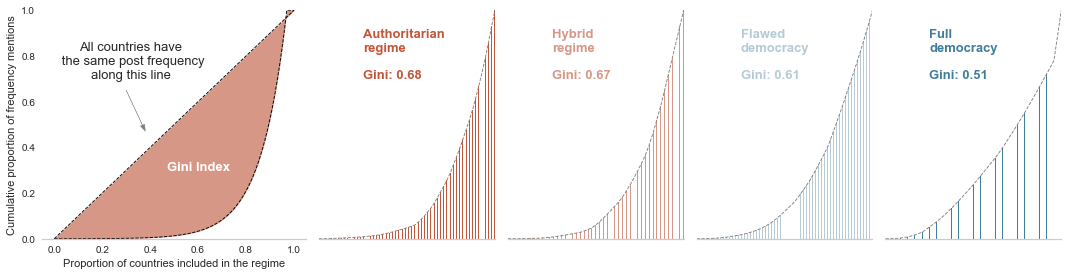

In [155]:
fig, ax = plt.subplots(1,5, figsize=(15,4), gridspec_kw={'width_ratios': [1.5, 1, 1, 1,1]})


ax[0].plot(np.linspace(0,1, 100),
          np.linspace(0,1, 100),
          color = 'black',
          linestyle = '--',
          linewidth = 0.9)

ax[0].plot(np.linspace(0,1, 100),
          np.cumsum(logsp)/sum(logsp),
          color = 'black',
          linestyle = '--',
          linewidth = 0.9)

ax[0].text(.32, .70, 'All countries have\n the same post frequency\nalong this line', rotation=0, fontsize=13, horizontalalignment='center')
ax[0].text(.60, .30, 'Gini Index', fontsize=13, color='white', fontweight='bold', horizontalalignment='center')

ax[0].set_xlabel("Proportion of countries included in the regime")
ax[0].set_ylabel("Cumulative proportion of frequency mentions")
ax[0].set_ylim((0,1))
ax[0].grid(None)
ax[0].fill_between(np.linspace(0,1,100), np.cumsum(logsp)/sum(logsp), np.linspace(0,1,100), color = colorcodes[1])
ax[0].arrow(.3, .65, 0.08, -0.18, length_includes_head=True, head_width=0.02, color='grey')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)

for i, c in enumerate(categories):
    k = i + 1
    ax[k].bar(np.linspace(0, 1, len(ginis_dict[c])),
             ginis_dict[c],
              width = 0.005,
             color=colorcodes[i])

    ax[k].plot(np.linspace(0, 1, len(ginis_dict[c])),
             ginis_dict[c],
              color = 'gray',
              linestyle='--',
              linewidth=0.9)

    ax[k].set_ylim((0,1))
    ax[k].set_xlim((0,1))

    ax[k].set_ylim((0, 1))
    ax[k].spines['top'].set_visible(False)
    ax[k].spines['right'].set_visible(False)
    ax[k].spines['left'].set_visible(False)
    ax[k].set_xticks([])
    ax[k].set_yticks([])
    ticklabel = "\n".join(c.split())
    ax[k].text(.25, .7, f'{ticklabel}\n\nGini: {np.round(gini(ginis_dict[c]),2)}', color=colorcodes[i], fontsize=13, fontweight='bold');
    
plt.tight_layout()
fig.savefig('gini_coef.png')

## 3.5. Calculating trade-off between sample size and representation

In this section, I look at how the Gini coefficient changes based on the subsampling value that was previously taken as 10. The logic is that if we take values greater than 10, the subsampling frequency will be smaller (since the top 20th frequency is lower than the top 10th frequency, for instnace). This will result in more countries being equally represented, but a smaller sample size overall. Note that once I choose the value, the same processing algorithm is employed as described in the paper.

In [771]:
sample_dir = f'.{os.sep}sampling_simulation{os.sep}'

In [772]:
# Create variable for storring the log
simulation_log = {}

Last time I looped only over the last few items, thus only N=14 to N=19 are printed out.

In [807]:
for n in range(2,20):

    # Get sampled data with the correct N
    print(f"Starting with N={n}")
    sampled_data = pd.DataFrame()
    for c in categories:
        sampled_data = pd.concat([sampled_data, subsample_regime(c, top_n=n)])

    print("Dropping duplicates")
    # Dropping duplicates
    sampled_data = sampled_data.drop_duplicates(subset=['body', 'date'])
    sample_size_min = sampled_data.outcome.value_counts().min()

    # Getting country weighs
    weighted_country_sizes = {}
    for c in categories:
        counts = sampled_data[sampled_data.outcome==c].countries.explode().value_counts()
        counts = counts.sort_values(ascending=True)

        weighted_country_sizes[c] = get_weighted_country_sizes(counts)

    # Extracting indices to use
    indices_to_use = []
    for categ in weighted_country_sizes.keys():
        for countr in weighted_country_sizes[categ]:
            elements_to_sample = weighted_country_sizes[categ][countr]
            index_local = sampled_data[sampled_data.countries.map(lambda ls: countr in ls)].index.tolist()
            indices_subset = random.sample(index_local, elements_to_sample)
            indices_to_use.extend(indices_subset)

    print("Cleaning data")        
    # Cleaning the data
    sampled_data = sampled_data.loc[indices_to_use].drop_duplicates(['body', 'date'])
    sample_data_min = sampled_data.outcome.value_counts().min()
    sampled_data = sampled_data.groupby('outcome').sample(sample_data_min, replace=False)

    # Logging the data for safety
    sampled_data.to_csv(f'{sample_dir}sampled_data_{n}')

    print("Getting gini coefficients")
    # Getting frequency counts
    ginis_dict = {}
    for c in categories:
        val_c = sampled_data[sampled_data.outcome == c].countries.explode().value_counts()
        val_c = val_c.sort_values(ascending=True).values
        ginis_dict[c] = np.cumsum((val_c) / val_c.sum())


    # Get Gini coeffs
    gini_coefs = {}
    for c in categories:
        gini_coefs[c] = gini(ginis_dict[c])

    # Get the length of a df
    gini_coefs['length'] = len(sampled_data)

    # Add the results to a dictionary
    simulation_log[n] = gini_coefs

Starting with N=14
Dropping duplicates
Cleaning data
Getting gini coefficients
Starting with N=15
Dropping duplicates
Cleaning data
Getting gini coefficients
Starting with N=16
Dropping duplicates
Cleaning data
Getting gini coefficients
Starting with N=17
Dropping duplicates
Cleaning data
Getting gini coefficients
Starting with N=18
Dropping duplicates
Cleaning data
Getting gini coefficients
Starting with N=19
Dropping duplicates
Cleaning data
Getting gini coefficients


## 3.6. Plotting Gini Coeff trade-off

In [828]:
# Convert to dataframe
simdf = pd.DataFrame(simulation_log).transpose().sort_index()
simdf['Gini'] = simdf[categories].mean(axis=1)

In [841]:
ginis = simdf['Gini']
results = simdf['length']

# Set colors and params
colors = ['#D79787' for x in range(len(results))]
edgecolors = ['none' for x in range(len(results))]
linestyles = ['--' for x in range(len(results))]

# Change params for my choice
colors[8] = '#C3553A'
edgecolors[8] = 'black'
linestyles[8] = '--'

In [846]:
# Create a legend
normal_patch = mpatches.Patch(color='#D79787', label='Number of posts')
custom_line = Line2D([0], [0], color='black', marker='o', lw=1, label = 'Mean Gini Coefficient')

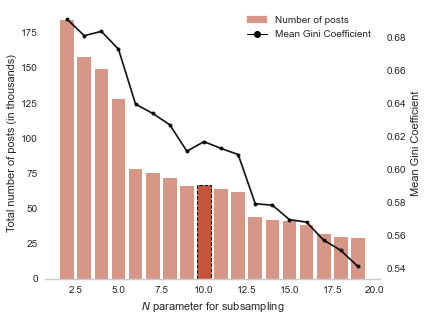

In [848]:
# Plot the figure
fig, ax = plt.subplots(1,1, figsize=(6,5))
ax2 = ax.twinx()
ax.bar(range(2,len(results)+2),
       [int(x/1000) for x in results],
       color = colors,
      edgecolor=edgecolors,
      linestyle='--',
      linewidth=1)

ax.set_xlabel("$N$ parameter for subsampling")
ax.set_ylabel("Total number of posts (in thousands)")
ax2.plot(range(2,len(results)+2),
       ginis,
      color='black',
     marker='o',
    markersize = 4, 
    alpha=0.9
)
ax.grid(None)
ax2.grid(None)
ax2.set_ylabel("Mean Gini Coefficient")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)


plt.legend(handles=[normal_patch, custom_line], loc = 'upper right', frameon=False)
fig.savefig('Gini_tradeoff.png')

## 3.7. Saving data subsample

In [394]:
sampled_data.to_csv('./data_processed/04-09_sampled_data.csv', index=False)

In [22]:
def load_sample_data():
    """Load the data to memory"""
    sampled_data = pd.read_csv('./data_processed/04-09_sampled_data.csv')

    countries_drop = ['uk', 'england', 'russia']
    
    # Convert the strings in the dataframe to lists
    for col in ['tokens', 'countries', 'regimes']:
        sampled_data = string2list(sampled_data, col)
    
    # Ensuring tokens dont have unnecessary words
    sampled_data['tokens'] = sampled_data['tokens'].map(lambda ls: [x for x in ls if x not in stopwords])
    sampled_data['tokens'] = sampled_data['tokens'].map(lambda ls: [x for x in ls if x.lower() not in countries_drop])
    
    return sampled_data

In [165]:
sampled_data = load_sample_data()

# 4. Analysis of the data

## 4.1. Dataset without subsampling

This part analyze the data without subsampling. This was used to complement some figures in the paper.

In [673]:
df = pd.read_csv("./data_processed/2021-04-08 processed.csv")

for col in ['countries', 'regimes']:
    df = string2list(df, col)

In [675]:
df['countries'] = df['countries'].map(lambda ls: [mapping.get(x, x) for x in ls])

In [676]:
df.outcome.value_counts()

Full democracy                    1712820
Authoritarian regime               151111
Flawed democracy                   124621
Hybrid regime                       90749
Democracy and Authoritarianism      81925
Other                               78251
None                                31858
Name: outcome, dtype: int64

In [677]:
def cap_top(series, n=25):
    """cap the series at some point to allow for better plotting"""
    
    # Get the top n value
    try:
        topn = series.iloc[n]
    except IndexError:
        return series
    
    # Calculate the sum of the remainder countries
    other = series[series<=topn].sum()
    
    # Calculate the index
    series_m = series[series>=topn].append(pd.Series(other))
    series_m.index = [i if i != 0 else 'Other' for i in series_m.index]
    
    return series_m

In [678]:
auth = df[df.outcome == 'Authoritarian regime']['countries'].explode().value_counts()

In [680]:
plot_vals = {}

for c in categories:
    plot_vals[c] = cap_top(df[df.outcome == c]['countries'].explode().value_counts(), n = 15)

In [698]:
# Create colors and mapping to colors
order = ['Authoritarian regime', 'Hybrid regime', 'Flawed democracy', 'Full democracy']
colorcodes = ['#C3553A', '#D79787', '#B6CBD6', '#407E9C']
cmapping = {k:v for k,v in zip(order, colorcodes)}

In [700]:
def legend_without_duplicate_labels(ax):
    """Create a legend without duplicates"""
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))


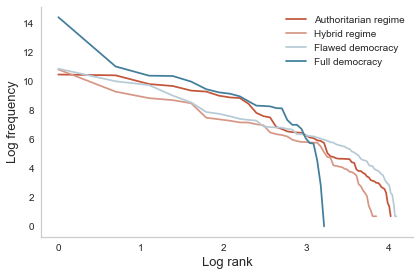

In [711]:
# Create a frequencies plot
fig, ax = plt.subplots(1, figsize=(6,4))


for i, c in enumerate(order):
    country_ranks = df[df.outcome==c].countries.explode().value_counts().sort_values(ascending=False)
    x = np.log(list(range(1,len(country_ranks) +1)))
    y = np.log(country_ranks.values)
    ax.plot(x, y, label = f'{c}', c = cmapping[c])
    
ax.grid(False)
ax.set_xlabel('Log rank', fontsize=13)
ax.set_ylabel('Log frequency', fontsize=13)
#ax.set_title("Rank-frequency distribution of countries", fontsize=13)
legend_without_duplicate_labels(ax)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
fig.savefig('frequencies_nosubs.png')

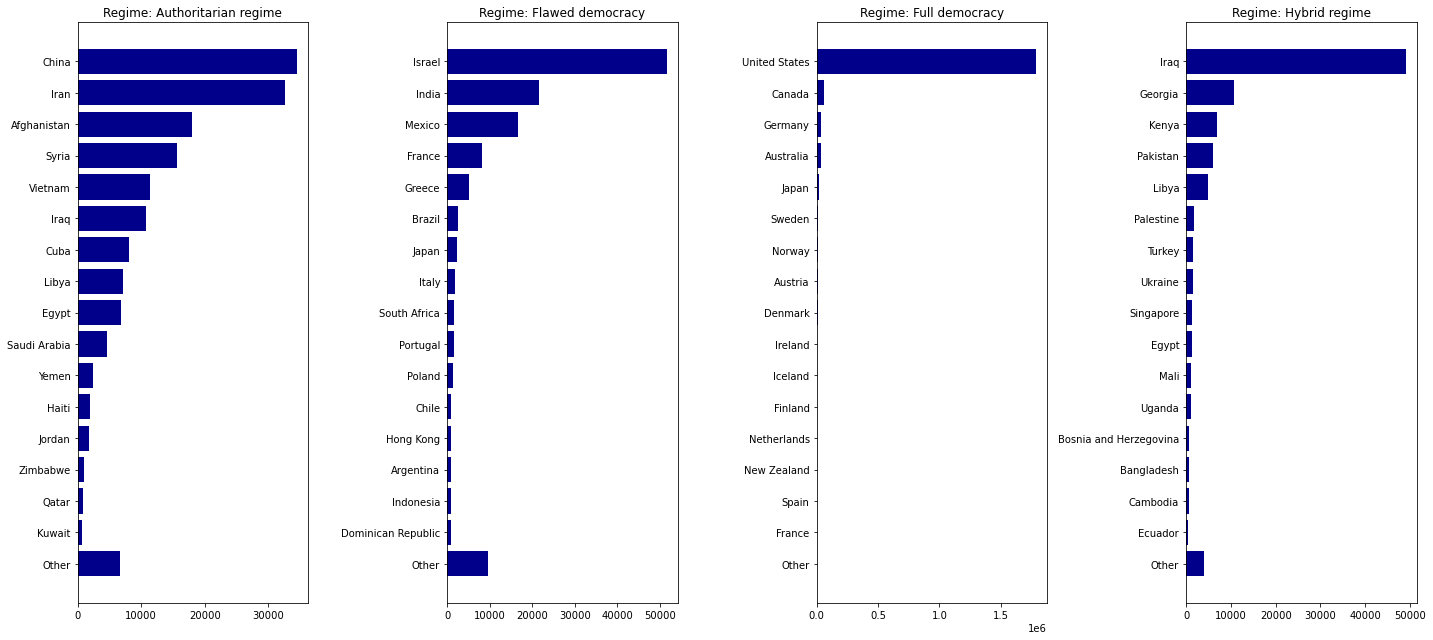

In [187]:
fig, axs = plt.subplots(1,4, figsize = (20,9))

ax_list = axs.flatten()

for i, c in enumerate(categories):
    ax_list[i].barh(plot_vals[c].keys()[::-1], plot_vals[c].values[::-1], color='darkblue')
    ax_list[i].set_title(f"Regime: {c}")
    
plt.tight_layout()
fig.savefig('country_distribution_regime.png')

In [ ]:
series_plot = cap_top(regimes_only, 3)

In [357]:
series_plot

Full democracy          1712820
Authoritarian regime     151111
Flawed democracy         124621
Hybrid regime             90749
Other                    282783
dtype: int64

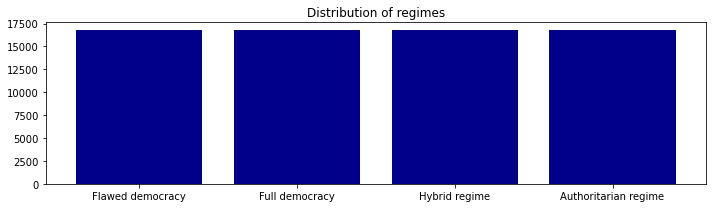

In [154]:
fig, ax = plt.subplots(1,1, figsize=(10,3))
plt.bar(series_plot.index, series_plot.values, color='darkblue')
ax.set_title("Distribution of regimes before subsampling")
plt.tight_layout()
fig.savefig('regime_distribution.png')

## 4.2. Dataset with subsampling

### 4.2.1. Frequencies

In [156]:
# Load the data
sampled_data = load_sample_data()
sampled_data = mask_country(sampled_data)

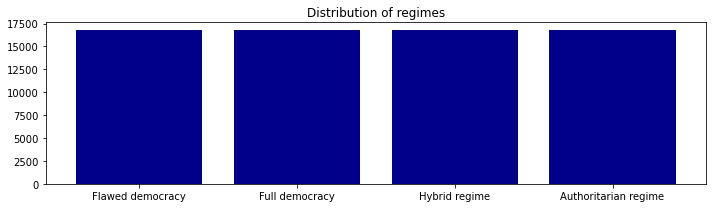

In [152]:
# Plot distribution of regimes with sampled data
series_plot = sampled_data.outcome.value_counts()
fig, ax = plt.subplots(1,1, figsize=(10,3))
plt.bar(series_plot.index, series_plot.values, color='darkblue')
ax.set_title("Distribution of regimes after sampling")
plt.tight_layout()
fig.savefig('regime_distribution_sample.png')

In [173]:
plot_vals = {}

for c in categories:
    plot_vals[c] = cap_top(sampled_data[sampled_data.outcome == c]['countries'].explode().value_counts(), n = 15)

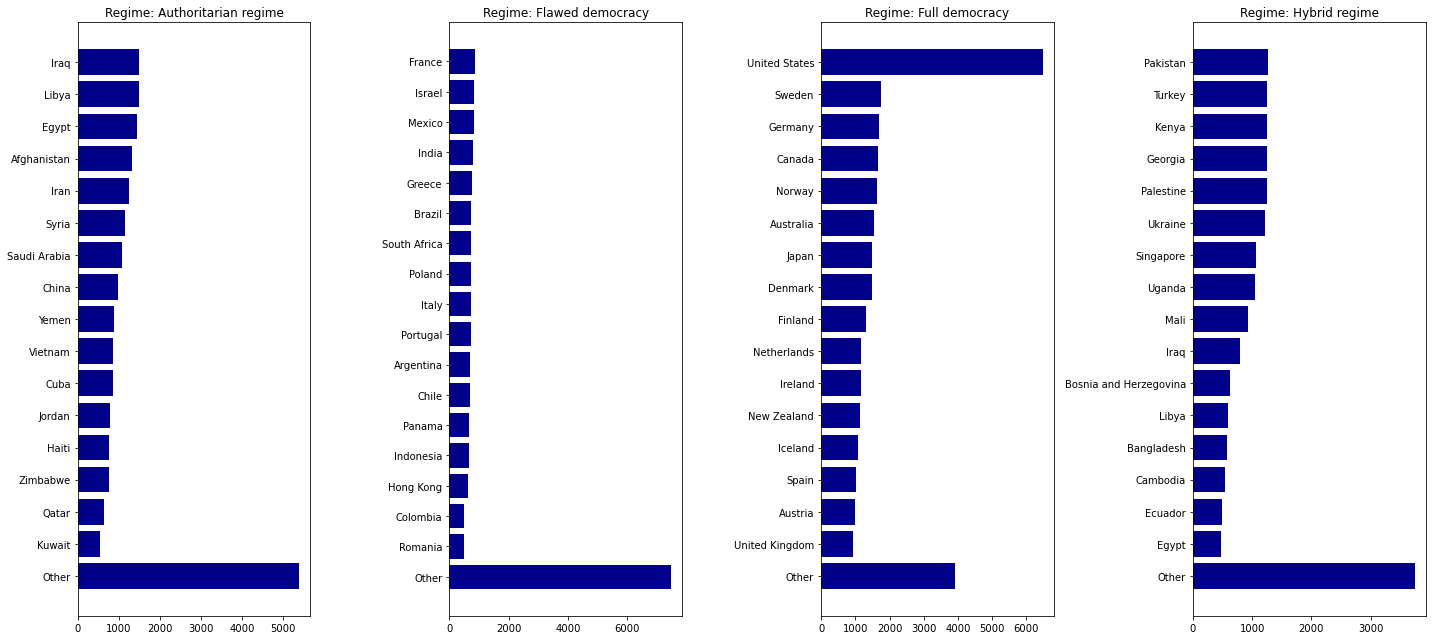

In [174]:
# Plot distribution of regimes for each country
fig, axs = plt.subplots(1,4, figsize = (20,9))

ax_list = axs.flatten()

for i, c in enumerate(categories):
    ax_list[i].barh(plot_vals[c].keys()[::-1], plot_vals[c].values[::-1], color='darkblue')
    ax_list[i].set_title(f"Regime: {c}")
    
plt.tight_layout()
fig.savefig('country_distribution_regime_after_sample_per_country.png')

In [162]:
plot_vals = {}

for c in categories:
    plot_vals[c] = cap_top(sampled_data[sampled_data.outcome == c]['countries'].map(lambda x: str(x)[2:-2]).value_counts(), n = 15)

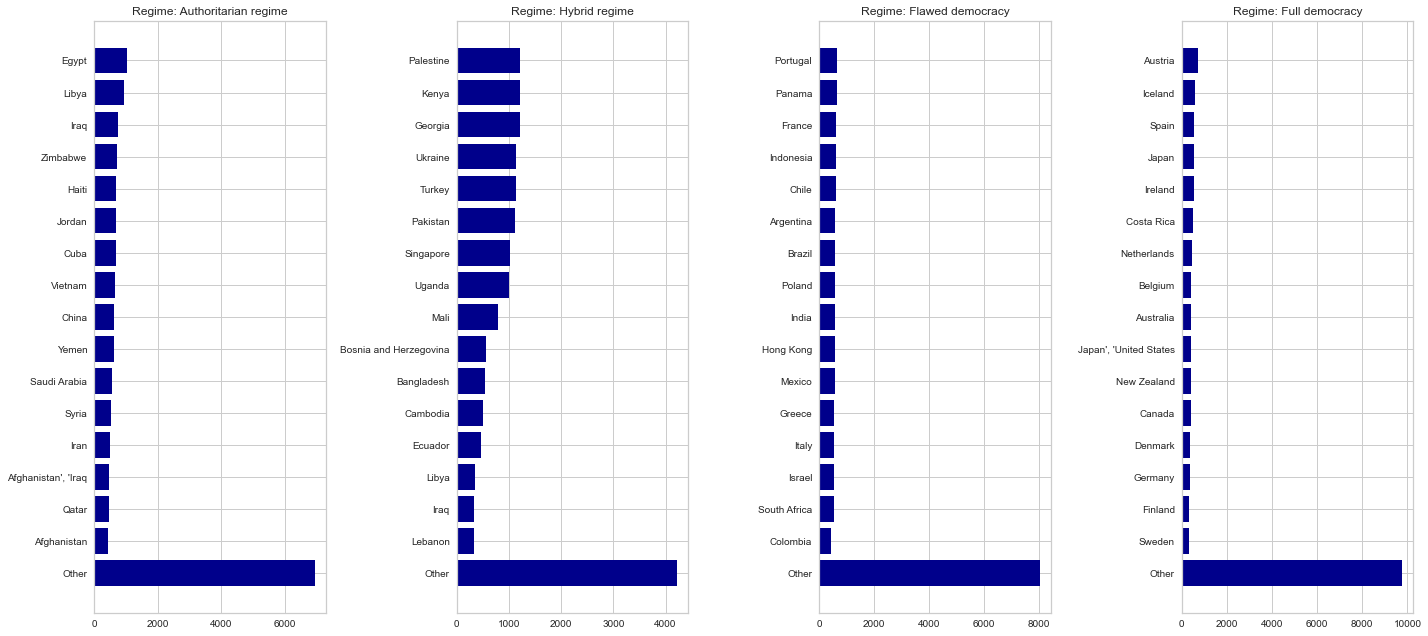

In [163]:
# Plot distribution of regimes for each combination of countries
fig, axs = plt.subplots(1,4, figsize = (20,9))

ax_list = axs.flatten()

for i, c in enumerate(categories):
    ax_list[i].barh(plot_vals[c].keys()[::-1], plot_vals[c].values[::-1], color='darkblue')
    ax_list[i].set_title(f"Regime: {c}")
    
plt.tight_layout()
#fig.savefig('country_distribution_regime_after_sample_category.png')

In [157]:
sampled_data.outcome.value_counts()

Authoritarian regime    16788
Flawed democracy        16788
Hybrid regime           16788
Full democracy          16788
Name: outcome, dtype: int64

### 4.2.2. Extracting train-test post data

In [23]:
def mask_country(sampled_data):
    sampled_data['tokens'] = sampled_data.tokens.map(lambda ls: ['[MASK]' if 'country' in x.lower() else x for x in ls]) # I had replaced all the countries by 'country' at some point. I also remove this word because it is a proxy for Europe
    
    return sampled_data

In [26]:
sampled_data = load_sample_data()
sampled_data = mask_country(sampled_data)
train_data, test_data = train_test_split(sampled_data, test_size=0.2, stratify=sampled_data['outcome'], random_state=42)

In [28]:
def get_vocab(sampled_data, categories, outcome_var):
    
    # Get dictionary
    vocab_dict = defaultdict(Counter)

    for c in categories:
        vocab = sampled_data.loc[sampled_data[outcome_var] == c, 'tokens'].tolist()
        for v in vocab:
            vocab_dict[c].update(v)

    total_vocab = []
    for c in categories:
        for k in vocab_dict[c].keys():
            total_vocab.append(k)

    total_vocab = set(total_vocab)
    
    return total_vocab, vocab_dict

In [29]:
# Get dictionary
vocab_dict = defaultdict(Counter)
categories = train_data.outcome.unique().tolist()

for c in categories:
    vocab = sampled_data.loc[sampled_data.outcome == c, 'tokens'].tolist()
    for v in vocab:
        vocab_dict[c].update(v)
        
total_vocab = []
for c in categories:
    for k in vocab_dict[c].keys():
        total_vocab.append(k)
        
total_vocab = set(total_vocab)

In [31]:
# Get train and test posts
train_posts = {}

for c in categories:
    train_posts[c] = []
    for ls in train_data.loc[train_data.outcome==c, 'tokens']:
        train_posts[c].append(ls)
        
test_posts = {}
test_countries = {}
correct_answers_test = []
for c in categories:
    test_posts[c] = []
    test_countries[c] = []
    for ls in test_data.loc[test_data.outcome==c, 'tokens']:
        test_posts[c].append(ls)
        correct_answers_test.append(c)
    for country in test_data.loc[test_data.outcome==c, 'countries']:
        test_countries[c].append(country)

In [33]:
for c in categories:
    train_tuples = set([tuple(x) for x in train_posts[c]])
    test_tuples = set([tuple(x) for x in test_posts[c]])

### 4.2.3. Rank-Frequency plots

In [172]:
colorcodes = ['#C3553A', '#D79787', '#B6CBD6', '#407E9C']

In [168]:
# Initialize data structures
vocab = defaultdict(Counter)
n_posts = defaultdict(Counter)

# Create vocabularies
for c_i in categories:
    for p in train_posts[c_i]:
        vocab[c_i].update(p)
        n_posts[c_i].update(set(p))

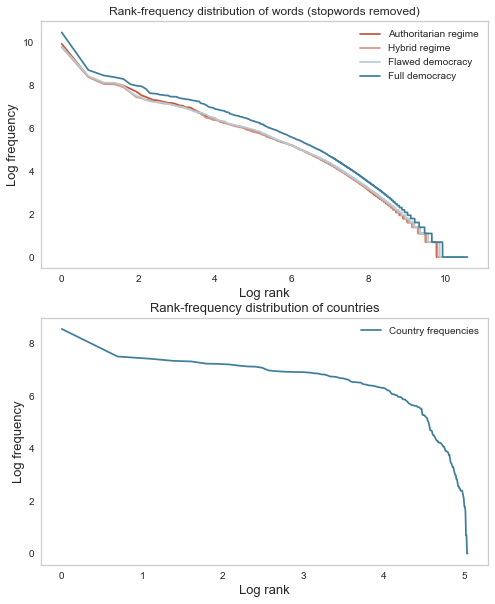

In [200]:
# Create plots of rank-frequency distributions for function words
fig, ax = plt.subplots(2,1, figsize=(8,10))

for i, c_i in enumerate(categories):

    y = np.log([c for w, c in vocab[c_i].most_common()])
    x = np.log(list(range(1, len(y) + 1)))
    ax[0].plot(x, y, label=c_i, c=colorcodes[i])

ax[0].set_title('Rank-frequency distribution of words (stopwords removed)')
ax[0].set_xlabel('Log rank', fontsize=13)
ax[0].set_ylabel('Log frequency', fontsize=13)
ax[0].legend()
ax[0].grid(False)

# Get country ranks
country_ranks = train_data.countries.explode().value_counts().sort_values(ascending=False)
x = np.log(list(range(1,len(country_ranks) +1)))
y = np.log(country_ranks.values)
ax[1].plot(x, y, label = 'Country frequencies', c = '#407E9C')
ax[1].grid(False)
ax[1].set_xlabel('Log rank', fontsize=13)
ax[1].set_ylabel('Log frequency', fontsize=13)
ax[1].set_title("Rank-frequency distribution of countries", fontsize=13)
ax[1].legend()

plt.show()
fig.savefig('rankfrequency.png')

### 4.2.4. Calculating post-level embeddings

In [242]:
from scipy import spatial

In [215]:
# Load fasttext embeddings
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
train_data['post_embedding'] = train_data.tokens.map(lambda ls: np.mean([ft.get_word_vector(x) for x in ls if x != '[MASK]'],axis=0))

In [278]:
print(f"Removing {len(train_data[train_data.post_embedding.map(lambda x: x.size != 300)])} posts since they only mention countries")
train_data = train_data[train_data.post_embedding.map(lambda x: x.size == 300)]

Removing 603 posts since they only mention countries


### 4.2.5. T-SNE plots

#### 4.2.5.1. Plotting T-SNE for embeddings

In [280]:
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, random_state=0)
tsne_results = tsne.fit_transform(list(train_data.post_embedding))

In [289]:
category2color = {c:k for c,k in zip(categories, colorcodes)}

In [307]:
# Assign a number to sample randomly each country
sample_vals = 1000

# Sample each country and subset the values
sample_ind = train_data.groupby('outcome').sample(sample_vals).index
subset_values = train_data.reset_index().loc[train_data.index.isin(sample_ind), 'index'].index

In [330]:
tsne_results2 = tsne_results[subset_values,:]

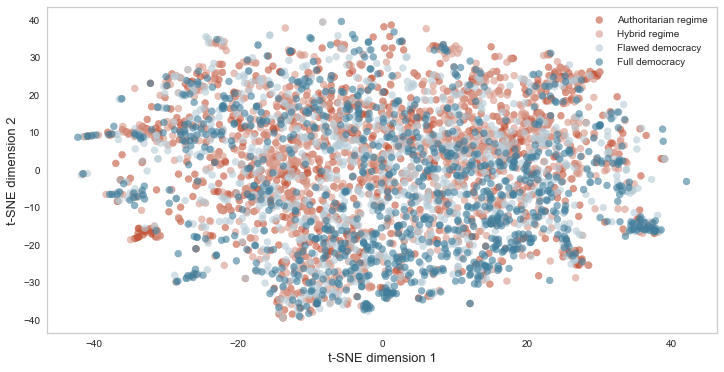

In [342]:
fig, ax = plt.subplots(1, figsize=(12, 6))
for c in categories:
    
    f_ = train_data.iloc[subset_values].outcome == c
    
    ax.scatter(tsne_results2[f_, 0], tsne_results2[f_, 1], 
               color= [category2color[c] for c in train_data.iloc[subset_values].loc[f_,'outcome']], 
               label = c,
               alpha=.6)

ax.legend()
ax.grid(False)
ax.set_xlabel("t-SNE dimension 1", fontsize=13)
ax.set_ylabel("t-SNE dimension 2", fontsize=13)
fig.savefig('tsne_4ksample.png')

#### 4.2.5.2. Plotting T-SNE for reddit comments

In [348]:
countylist = np.unique(list(train_data.countries.explode().values))

In [352]:
c_embedding = {k: ft.get_word_vector(k) for k in countrylist}

In [356]:
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, random_state=0)
tsne_countries = tsne.fit_transform(list(c_embedding.values()))

In [379]:
def legend_without_duplicate_labels(ax):
    """Remove duplicate labels"""
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))


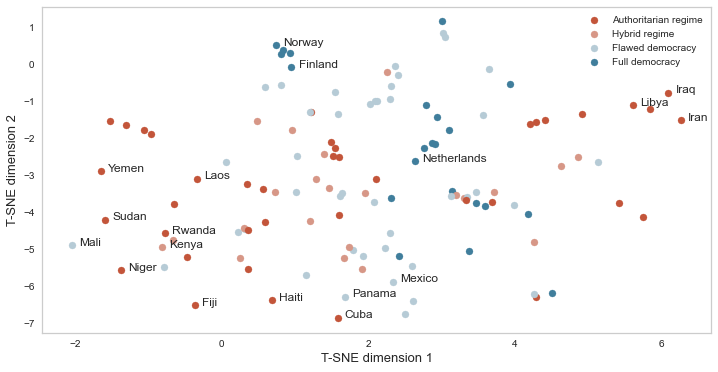

In [397]:
fig, ax = plt.subplots(1, figsize=(12,6))
for w, p in zip(c_embedding.keys(), tsne_countries):
    if democracy_mapped.get(w) is None:
        continue
    ax.scatter(p[0], p[1],
               color=category2color[democracy_mapped.get(w)],
              label=democracy_mapped.get(w))
    
    if w in ['Norway', 'Finland', 'Iraq', 'Libya', 'Iran', 'Rwanda', 'Kenya', 'Yemen', 'Sudan', 'Mali', 'Niger', 'Netherlands', 'Mexico', 'Panama', 'Haiti', 'Cuba', 'Fiji', 'Laos']:
        ax.text(p[0] + 0.1, p[1] - 0.05, w, fontsize=12, ha='left', va='bottom',)
    
legend_without_duplicate_labels(ax)
ax.grid(False)
ax.set_xlabel("T-SNE dimension 1", fontsize=13)
ax.set_ylabel("T-SNE dimension 2", fontsize=13)
fig.savefig('tsnecountries.png')

#### 4.2.5.3. Combining the two T-SNE plots

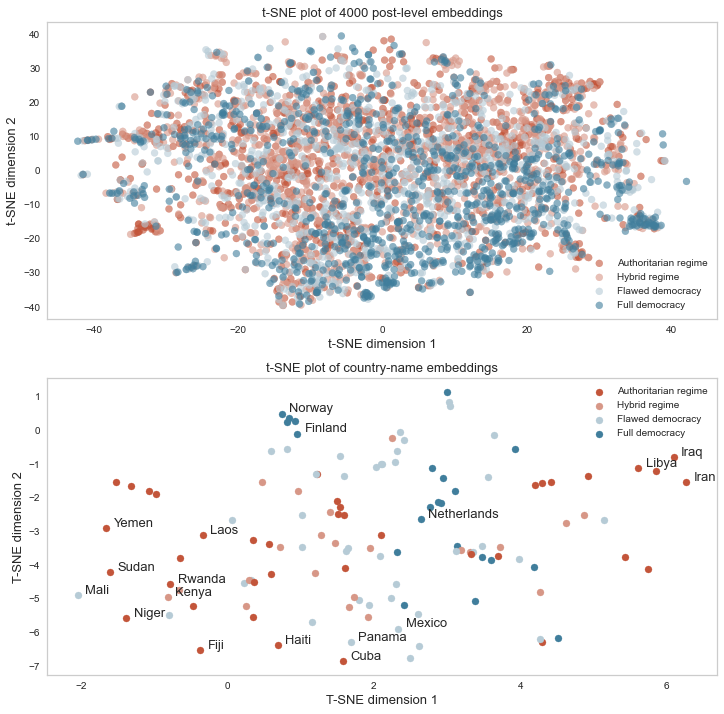

In [403]:
fig, ax = plt.subplots(2,1, figsize=(12,12))

# Plot one
for c in categories:
    
    f_ = train_data.iloc[subset_values].outcome == c
    
    ax[0].scatter(tsne_results2[f_, 0], tsne_results2[f_, 1], 
               color= [category2color[c] for c in train_data.iloc[subset_values].loc[f_,'outcome']], 
               label = c,
               alpha=.6)

ax[0].legend()
ax[0].grid(False)
ax[0].set_xlabel("t-SNE dimension 1", fontsize=13)
ax[0].set_ylabel("t-SNE dimension 2", fontsize=13)
ax[0].set_title("t-SNE plot of 4000 post-level embeddings", fontsize=13)

# Plot Two
for w, p in zip(c_embedding.keys(), tsne_countries):
    if democracy_mapped.get(w) is None:
        continue
    ax[1].scatter(p[0], p[1],
               color=category2color[democracy_mapped.get(w)],
              label=democracy_mapped.get(w))
    
    if w in ['Norway', 'Finland', 'Iraq', 'Libya', 'Iran', 'Rwanda', 'Kenya', 'Yemen', 'Sudan', 'Mali', 'Niger', 'Netherlands', 'Mexico', 'Panama', 'Haiti', 'Cuba', 'Fiji', 'Laos']:
        ax[1].text(p[0] + 0.1, p[1] - 0.05, w, fontsize=13, ha='left', va='bottom',)
    
legend_without_duplicate_labels(ax[1])
ax[1].grid(False)
ax[1].set_xlabel("T-SNE dimension 1", fontsize=13)
ax[1].set_ylabel("T-SNE dimension 2", fontsize=13)
ax[1].set_title("t-SNE plot of country-name embeddings", fontsize=13)

fig.savefig('tsne_grouped.png')

### 4.2.6. Nearest neighbor analysis

In [421]:
emb1 = train_data.post_embedding.iloc[0]
emb2 = train_data.post_embedding.iloc[1]

In [661]:
from scipy import spatial
from matplotlib.offsetbox import AnchoredOffsetbox, HPacker, VPacker, TextArea, PaddedBox
import matplotlib.patches as patches


In [567]:
data_subset = train_data.groupby('outcome').sample(1000)

In [568]:
cosine_sims_posts = {}
for ind in data_subset.index:
    embed1 = data_subset.loc[ind, 'post_embedding']
    cosine_sims_posts[ind] = data_subset.post_embedding.map(lambda x: 1 - spatial.distance.cosine(embed1, x))

In [569]:
cos_df = pd.DataFrame(cosine_sims_posts)

In [570]:
cos_df.head()

,10659,9228,15322,15408,14808,5272,4590,969,13557,11442,...,58666,60030,50945,57673,53824,57531,53792,66538,61691,60982
10659,1.000000,0.285732,0.398701,0.361115,0.315285,0.304319,0.526039,0.243735,0.501404,0.356741,...,0.411603,0.277401,0.391103,0.377901,0.480521,0.226653,0.437879,0.296229,0.482495,0.512960
9228,0.285732,1.000000,0.437977,0.538306,0.509319,0.601862,0.499678,0.405259,0.627364,0.529888,...,0.623512,0.323143,0.561255,0.583441,0.611373,0.531498,0.682973,0.500510,0.616404,0.664081
15322,0.398701,0.437977,1.000000,0.452117,0.393887,0.453198,0.458324,0.334583,0.488508,0.543132,...,0.530864,0.394769,0.545139,0.402508,0.588120,0.352332,0.497789,0.452900,0.658788,0.670820
15408,0.361115,0.538306,0.452117,1.000000,0.446281,0.755692,0.560409,0.343510,0.596419,0.577657,...,0.576130,0.547809,0.584024,0.467670,0.760499,0.332495,0.614548,0.540215,0.739274,0.681842
14808,0.315285,0.509319,0.393887,0.446281,1.000000,0.432286,0.558671,0.534601,0.580443,0.521691,...,0.589262,0.391202,0.510446,0.442219,0.546793,0.325082,0.652102,0.498866,0.533117,0.566482


In [571]:
# Create dictionaries for storing nearest neighbors

# Nearest neighbors of the posts
nnbs = {}
for category in categories: nnbs[category] = []

# Nearest neighbors of the countries, top 10
cnbs10 = {}
for category in categories:cnbs10[category] = []
    
# Nearest neighbors of the countries, top 50
cnbs50 = {}
for category in categories:cnbs50[category] = []

In [572]:
# Assign variables: sample 10, 50 countries and 100 posts.
# In the paper, 100 nearest neighbors are used for the posts and 10 for the countries

n_country1=10
n_country2=50
n_regime=101
for ind in cos_df.columns:
    
    # Get the subset of the data
    s_index = cos_df[ind].sort_values(ascending=False)[1:n_regime].index
    s_regimes = data_subset.loc[s_index, 'outcome']
    s_outcome = data_subset.loc[ind, 'outcome']
    
    # Get countries
    s_countries = data_subset.loc[s_index, 'countries']
    s_country = data_subset.loc[ind, 'countries']
    
    apps = []
    apps2 = []
    for country in s_country:
    # Check if the country is in the top 10  or top 50 countries
        number_appearances_country = s_countries[:n_country1].map(lambda ls: country in ls).sum()
        apps.append(number_appearances_country)
        
        number_appearances_country = s_countries[:n_country2].map(lambda ls: country in ls).sum()
        apps2.append(number_appearances_country)
    
    # Calculate the average number of neighbors
    avg_neighbors = (s_regimes == s_outcome).mean()
    
    nnbs[s_outcome].append(avg_neighbors)
    cnbs10[s_outcome].extend(apps)
    cnbs50[s_outcome].extend(apps2)

In [573]:
np.array(cnbs50['Full democracy']).mean()

4.519758507135016

In [574]:
a_file = open("nnbs.pkl", "wb")
pickle.dump(nnbs, a_file)
a_file.close()

In [663]:
# Load the data
a_file = open("nnbs.pkl", "rb")
df = pickle.load(a_file)
a_file.close()

# Convert the dataframe and add colorcodes
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in df.items() ]))

df2 = pd.melt(df)

order = ['Authoritarian regime', 'Hybrid regime', 'Flawed democracy', 'Full democracy']
colorcodes = ['#C3553A', '#D79787', '#B6CBD6', '#407E9C']
order = order[::-1]
colorcodes = colorcodes[::-1]


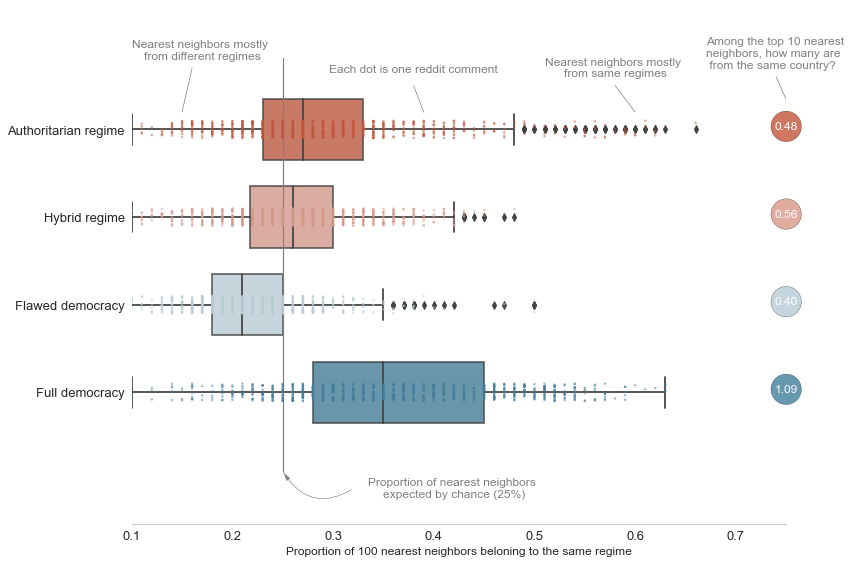

In [672]:
fig, ax = plt.subplots(1,figsize=(12,8))

# Set text color
ct= 'grey'
wt = None

sns.boxplot(x='value', y='variable', data=df2, width=0.7, ax=ax, orient='h', 
            order=order, palette=colorcodes, boxprops=dict(alpha=.8),
            saturation=.9)

# Add stripplot
sns.stripplot(x='value', y='variable', data=df2, marker='o', size=2.5, alpha=0.5, ax=ax, order=order, palette=colorcodes)

ax.set_xlim((0.1, .75))
ax.set_ylim((-1.5,4.4))

for sp in ['right', 'top', 'left']: 
    ax.spines[sp].set_visible(False)

ax.axvline(x=0.25, color='grey', linewidth=1.2, ymin=0.1, ymax=0.9);

# Adding circles

xcircle = 0.75

pad=0.3
ax.annotate("0.48", xy=(xcircle,3),  fontsize=12, color='white', ha='center',
            bbox={'boxstyle': 'circle', 'pad': pad, 'facecolor': colorcodes[-1], 'edgecolor': 'black', 'alpha':0.8})

ax.annotate("0.56", xy=(xcircle,2),  fontsize=12, color='white', ha='center',
            bbox={'boxstyle': 'circle', 'pad': pad, 'facecolor': colorcodes[-2], 'edgecolor': 'black', 'alpha':0.8})

ax.annotate("0.40", xy=(xcircle,1),  fontsize=12, color='white', ha='center',
            bbox={'boxstyle': 'circle', 'pad': pad, 'facecolor': colorcodes[-3], 'edgecolor': 'black', 'alpha':0.8})


ax.annotate("1.09", xy=(xcircle,0),  fontsize=12, color='white', ha='center',
            bbox={'boxstyle': 'circle', 'pad': pad, 'facecolor': colorcodes[-4], 'edgecolor': 'black', 'alpha':0.8})

# Set explanations
fonttext = 12
ax.plot([0.39, 0.38], [3.2,3.5], linewidth=.7, color=ct)
ax.annotate('Each dot is one reddit comment', xy=(0.38,3.65),  fontsize=fonttext, weight=wt, color=ct, ha='center')

ax.plot([0.15, 0.16], [3.2,3.7], linewidth=.7, color=ct)
ax.annotate('Nearest neighbors mostly \nfrom different regimes', xy=(0.17,3.8), weight=wt,  fontsize=fonttext, color=ct, ha='center')

ax.plot([0.60, 0.58], [3.2,3.5], linewidth=.7, color=ct)
ax.annotate('Nearest neighbors mostly \nfrom same regimes', xy=(0.58,3.6), weight=wt,  fontsize=fonttext, color=ct, ha='center')


# Set nearest neighbors label
ax.annotate('Proportion of nearest neighbors \nexpected by chance (25%)', xy=(0.42,-1.2), weight=wt, fontsize=fonttext, color=ct, ha='center')

style = "Simple, tail_width=0, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="grey")

a1 = patches.FancyArrowPatch((0.32,-1.1), (0.25,-0.9), connectionstyle='arc3, rad=-.5', **kw)
plt.gca().add_patch(a1)

ax.annotate('Among the top 10 nearest \nneighbors, how many are\n from the same country?', xy=(0.67,3.7),  fontsize=12, color=ct, weight=wt, ha='left')
ax.plot([0.74, 0.75], [3.6,3.34], linewidth=.7, color=ct)

# Add other small parameters
ax.set_ylabel("")
ax.set_xlabel("Proportion of 100 nearest neighbors beloning to the same regime", fontsize=fonttext)
plt.xticks(size=13)
plt.yticks(size=13)
ax.grid(False)
plt.tight_layout()
plt.show()

#fig.savefig('boxplots_regime.png')

# 5. Naive Bayes

## 5.1. Set-up and tuning

In [772]:
# Define function to train Naive Bayes
def nb_c(vocab, categories, delta):

    # Calculate number of unseen words for both categories
    vocab_sizes = defaultdict(dict)
    for c_i in categories:
        vocab_sizes[c_i]['seen'] = len(vocab[c_i])
        for c_j in categories:
            if c_i == c_j:
                continue
            vocab_sizes[c_i]['unseen'] = len([w for w in vocab[c_j] if vocab[c_i][w] == 0])

    # Calculate smoothed probabilities
    probs = dict()
    counts = dict()
    for c_i in categories:
        probs[c_i] = {w: vocab[c_i][w] - delta for w in vocab[c_i]}
        for c_j in categories:
            if c_i == c_j:
                continue
            for w in vocab[c_j]:
                if vocab[c_i][w] == 0:
                    probs[c_i][w] = delta * (vocab_sizes[c_i]['seen'] / vocab_sizes[c_i]['unseen'])
    
        # Store adjusted counts
        counts[c_i] = probs[c_i]

        total = sum(probs[c_i].values())
        probs[c_i] = {w: probs[c_i][w] / total for w in probs[c_i]}
    return probs, counts

In [871]:
def predict_bayes(categories, test_posts, probs):
    # Initialize lists for storing ground truth labels and predictions
    labels = []
    preds = []

    # Loop over categories
    for c_i in categories:

        # Loop over test posts
        for p in test_posts[c_i]:

            # Store ground truth
            labels.append(c_i)

            # Calculate scores for categories
            scores = {'Full democracy': 0,
                      'Flawed democracy': 0,
                      'Hybrid regime': 0,
                      'Authoritarian regime': 0}

            for w in p:
                if w in probs[c_i]:
                    scores['Full democracy'] += np.log(probs['Full democracy'][w])
                    scores['Flawed democracy'] += np.log(probs['Flawed democracy'][w])
                    scores['Hybrid regime'] += np.log(probs['Hybrid regime'][w])
                    scores['Authoritarian regime'] += np.log(probs['Authoritarian regime'][w])


            # Use higher score for prediction
            preds.append(max(scores.items(), key=operator.itemgetter(1))[0])

    print('Accuracy: {:.3f}'.format(len([(l, p) for l, p in zip(labels, preds) if l == p]) / len(labels)))
    
    return labels, preds

In [773]:
# Initialize deltas
deltas = np.arange(0.95, 0.0, -0.05)

In [774]:
len(train_posts['Hybrid regime'])

13430

In [775]:
def perform_CV_bayes(train_posts, deltas):
    # Perform cross-validation
    
    # Initialize data structures
    accs = list()
    c_0_smoothed = defaultdict(list)
    c_1_smoothed = defaultdict(list)
    
    for d in deltas:

        # Shuffle training data
        for c_i in categories:
            random.shuffle(train_posts[c_i])

        # Define total number of train posts and step size
        n = len(train_posts['Hybrid regime'])
        s = int(len(train_posts['Hybrid regime']) / 5)

        # Initialize list for storing accuracy values
        dev_accs = list()

        # Initialize dictionaries for storing adjusted counts
        c_0 = defaultdict(list)
        c_1 = defaultdict(list)

        for i in range(0, n, s):

            # Initialize training vocabularies
            vocab_train = defaultdict(Counter)

            for c_i in categories:

                # Loop over cross-validation train posts
                for p in train_posts[c_i][:i] + train_posts[c_i][i+s:]:

                    # Only add content words not in set for removal
                    vocab_train[c_i].update([w for w in p])

            # Train Naive Bayes
            probs, counts = nb_c(vocab_train, categories, d)

            # Store adjusted counts
            for c_i in categories:
                c_0[c_i].append([c for w, c in counts[c_i].items() if vocab_train[c_i][w] == 0][0])
                c_1[c_i].append([c for w, c in counts[c_i].items() if vocab_train[c_i][w] == 1][0])

            # Initialize lists for storing ground truth labels and predictions
            labels = list()
            preds = list()

            # Loop over categories
            for c_i in categories:

                # Loop over cross-validation dev posts
                for p in train_posts[c_i][i:i+s]:

                    # Store ground truth
                    labels.append(c_i)

                    # Calculate scores for dictatorship categories
                    scores = {'Full democracy': 0,
                              'Flawed democracy': 0,
                              'Hybrid regime': 0,
                              'Authoritarian regime': 0}
                    
                    for w in p:
                        if w in probs[c_i]:
                            scores['Full democracy'] += np.log(probs['Full democracy'][w])
                            scores['Flawed democracy'] += np.log(probs['Flawed democracy'][w])
                            scores['Hybrid regime'] += np.log(probs['Hybrid regime'][w])
                            scores['Authoritarian regime'] += np.log(probs['Authoritarian regime'][w])

                    # Use higher score for prediction
                    preds.append(max(scores.items(), key=operator.itemgetter(1))[0])

            dev_accs.append(len([(l, p) for l, p in zip(labels, preds) if l == p]) / len(labels))

        # Store mean adjusted counts for delta
        for c_i in categories:
            c_0_smoothed[c_i].append(np.mean(c_0[c_i]))
            c_1_smoothed[c_i].append(np.mean(c_1[c_i]))


        accs.append(dev_accs)        
        print('Mean accuracy for delta of {:.2f}: {:.3f}. Accuracies: {}'.format(d, np.mean(dev_accs), dev_accs))
    return accs

In [58]:
accs = perform_CV_bayes(train_posts, deltas)

Mean accuracy for delta of 0.95: 0.452. Accuracies: [0.45085629188384213, 0.45569620253164556, 0.4513216679076694, 0.4465748324646314, 0.45606850335070737]
Mean accuracy for delta of 0.90: 0.457. Accuracies: [0.4462956068503351, 0.46081533879374537, 0.45839538346984365, 0.4590469099032018, 0.45951228592702903]
Mean accuracy for delta of 0.85: 0.461. Accuracies: [0.4633283693224125, 0.45793000744601636, 0.4659344750558451, 0.45765078183172003, 0.4607222635889799]
Mean accuracy for delta of 0.80: 0.465. Accuracies: [0.4673306031273269, 0.4616530156366344, 0.46416604616530155, 0.47077438570364855, 0.4587676842889054]
Mean accuracy for delta of 0.75: 0.467. Accuracies: [0.47133283693224126, 0.45951228592702903, 0.466120625465376, 0.4659344750558451, 0.4725428145941921]
Mean accuracy for delta of 0.70: 0.470. Accuracies: [0.4701228592702904, 0.4716120625465376, 0.4710536113179449, 0.4640729709605361, 0.47468354430379744]
Mean accuracy for delta of 0.65: 0.474. Accuracies: [0.468912881608339

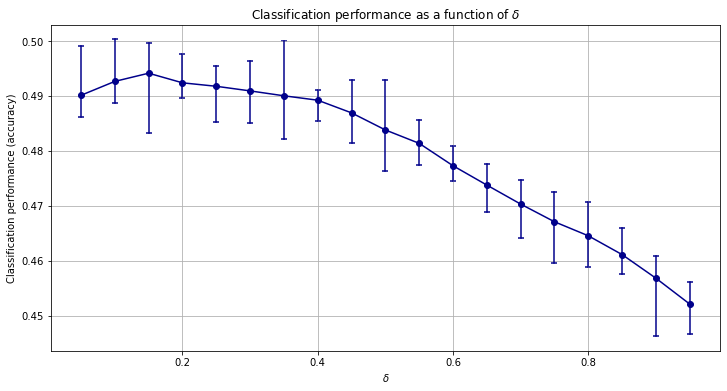

In [64]:
# Get input variables
means = np.mean(accs[:], axis=1)
maxs = np.max(accs[:], axis=1)
mins = np.min(accs[:], axis=1)
line_helper = [(x,y) for x,y in zip(mins, maxs)]

# Create plot of classification performance as a function of delta
fig, ax = plt.subplots(1, figsize=(12, 6))
color = 'darkblue'

ax.plot(deltas, means, marker='o', color=color)
ax.scatter(deltas, maxs , linestyle='-', marker = '_', color=color)
ax.scatter(deltas, mins, linestyle='-', marker = '_', color=color)
plt.plot((deltas, deltas), ([i for (i,j) in line_helper], [j for (i,j) in line_helper]), c=color)
ax.set_title('Classification performance as a function of $\delta$')
ax.set_xlabel('$\delta$')
ax.set_ylabel('Classification performance (accuracy)')

plt.grid()
plt.show()
fig.savefig('delta_parameter_classification_v2.png')

## 5.2. Naive Bayes between categories - unigrams

In [795]:
# Get dictionary
vocab_dict = defaultdict(Counter)
categories = train_data.outcome.unique().tolist()

for c in categories:
    vocab = train_data.loc[train_data.outcome == c, 'tokens'].tolist()
    for v in vocab:
        vocab_dict[c].update(v)

In [796]:
vocab_train = defaultdict(Counter)
for c_i in categories:
    vocab_train[c_i] = Counter({w: vocab_dict[c_i][w] for w in vocab_dict[c_i]})
    

In [797]:
# Train Naive Bayes
probs, _ = nb_c(vocab_train, categories, d)

labels, preds = predict_bayes(categories, test_posts, probs)

Accuracy: 0.500


In [876]:
def plot_conf_matrix(predicted, y_test, savefig=True, fignm='conf_matrix_naivebayes.png'):
    """
    Plots a confusion matrix based on the predicted and 
    actual y values
    """
    
    tickmarks = ['Full democracy','Flawed democracy', 'Hybrid regime', 'Authoritarian regime']
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    fig, ax = plt.subplots(figsize=(12,7))
    sns.heatmap(confusion_matrix(predicted, y_test, labels = tickmarks), annot = True, fmt = 'g', linecolor = 'white', linewidths=12, cmap=cmap)
    ax.set_xlabel("Actual regime")
    ax.set_ylabel("Predicted regime")
    ax.set_title("Confusion matrix for a four-way regime classification")
    ax.set_xticklabels(tickmarks)
    ax.set_yticklabels(tickmarks)
    plt.yticks(np.arange(4)+0.5,('Full democracy', 'Flawed democracy', 'Hybrid regime', 'Authoritarian regime'), rotation=0, fontsize="10", va="center")
    
    if savefig: fig.savefig(fignm)

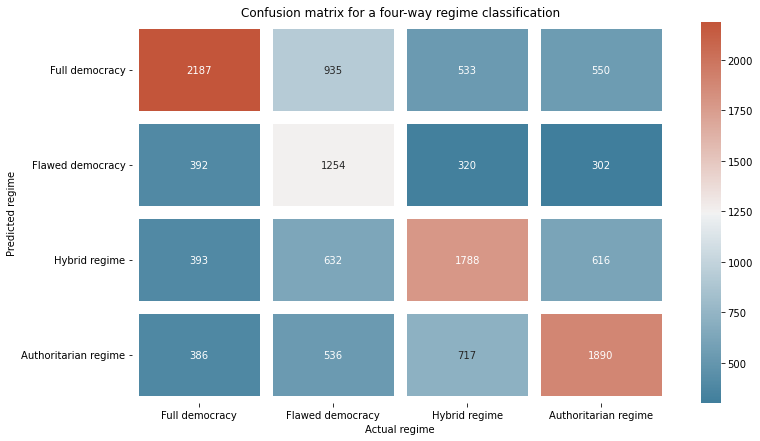

In [120]:
plot_conf_matrix(preds, labels, savefig=True)

## 5.3. Naive Bayes between categories - bigrams

In [816]:
vocab_bi = defaultdict(Counter)

# Create vocabularies
for a, l in zip(train_data.tokens, train_data.outcome):
    vocab_bi[l].update(nltk.bigrams([w for w in a if w not in stopwords and w != '[MASK]']))

In [818]:
# Inspect most frequent bigrams
for l in categories:
    print('30 most frequent bigrams in {} abstracts:'.format(l), vocab_bi[l].most_common(30))
    print()

30 most frequent bigrams in Authoritarian regime abstracts: [(('dont', 'think'), 307), (('dont', 'know'), 293), (('im', 'sure'), 244), (('middle', 'east'), 221), (('human', 'rights'), 165), (('al', 'qaeda'), 156), (('dont', 'want'), 155), (('foreign', 'policy'), 147), (('ron', 'paul'), 145), (('health', 'care'), 143), (('years', 'ago'), 143), (('bin', 'laden'), 141), (('just', 'like'), 136), (('civil', 'war'), 136), (('doesnt', 'mean'), 132), (('dont', 'like'), 130), (('fox', 'news'), 119), (('al', 'jazeera'), 119), (('people', 'dont'), 110), (('im', 'saying'), 99), (('people', 'like'), 91), (('dont', 'care'), 91), (('sounds', 'like'), 89), (('things', 'like'), 89), (('im', 'going'), 88), (('civil', 'rights'), 82), (('just', 'dont'), 81), (('patriot', 'act'), 78), (('minimum', 'wage'), 77), (('tax', 'cuts'), 76)]

30 most frequent bigrams in Flawed democracy abstracts: [(('dont', 'think'), 328), (('dont', 'know'), 288), (('im', 'sure'), 208), (('years', 'ago'), 193), (('health', 'care'

In [837]:
# Get posts
train_posts_bi = {}

for c in categories:
    train_posts_bi[c] = []
    for ls in train_data.loc[train_data.outcome==c, 'tokens']:
        train_posts_bi[c].append(list(nltk.bigrams(ls)))


In [838]:
# Checking for two accuracies
accs_bi = perform_CV_bayes(train_posts_bi, [0.05, 0.1])

Mean accuracy for delta of 0.05: 0.477. Accuracies: [0.4691509433962264, 0.46641509433962264, 0.4670754716981132, 0.45933962264150946, 0.4634261444077395, 0.5365853658536586]
Mean accuracy for delta of 0.10: 0.497. Accuracies: [0.47462264150943395, 0.47, 0.4700943396226415, 0.47650943396226414, 0.473147711184521, 0.6178861788617886]


In [873]:
# Train Naive Bayes
probs_bi, _ = nb_c(vocab_bi, categories, d)

In [874]:
test_posts_bi = {}

for c in categories:
    test_posts_bi[c] = []
    for ls in test_data.loc[test_data.outcome==c, 'tokens']:
        test_posts_bi[c].append(list(nltk.bigrams(ls)))


In [875]:
labels, preds = predict_bayes(categories, test_posts_bi, probs_bi)

Accuracy: 0.427


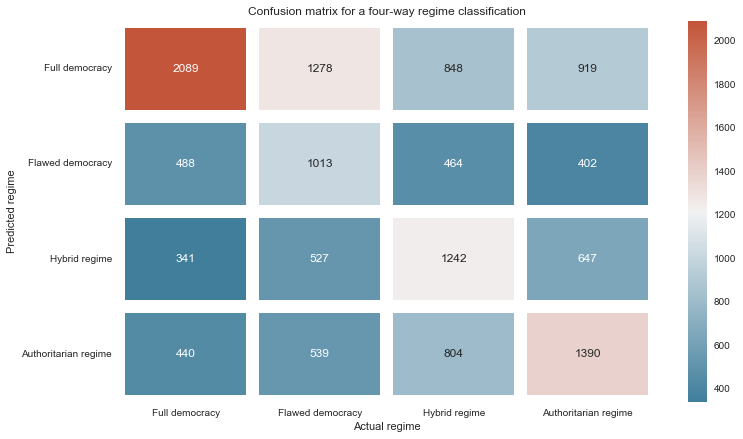

In [878]:
plot_conf_matrix(preds, labels, savefig=True, fignm='bigram_conf.png')

## 5.4. Naive Bayes between countries

Classify within top 10 and then just leave it as others.

1. Get the top 10 countries
2. Change the other countries as 'other'
3. Drop out times when mentions two or more countries
4. Build a classifier (word probabilities)
5. Evaluate

In [294]:
sampled_data.outcome.value_counts()

Flawed democracy        16788
Full democracy          16788
Hybrid regime           16788
Authoritarian regime    16788
Name: outcome, dtype: int64

Get the top 10 countries

In [298]:
def get_top_countries(sampled_data, regime='Full democracy', n=15):
    countries = sampled_data[sampled_data.outcome == regime].countries.apply(tuple).value_counts()
    countries_top = countries[(pd.Series(countries.index).map(len) == 1).tolist()][:n].index.tolist()
    countries_top = [x[0] for x in countries_top]
    
    return countries_top

Drop out countries that are mentioned more than once and change the name to other

In [299]:
def filter_and_split(sampled_data, to_display=True, regime='Full democracy'):
    
    democracy_df = sampled_data[sampled_data.outcome == regime].copy()
    democracy_df = democracy_df[~(democracy_df.countries.map(len) > 1)]
    democracy_df['outcome_country'] = democracy_df.countries.map(lambda c: c[0] if c[0] in countries_top else 'Other')
    
    if to_display:
        print(f"Regime {regime} top countries: ")
        display(democracy_df['outcome_country'].value_counts())

    # Split the data
    train_data = democracy_df.sample(frac=0.8)
    test_indices = [ind for ind in democracy_df.index if ind not in train_data.index]
    test_data = democracy_df.loc[test_indices].copy()

    assert len(train_data) + len(test_data) == len(democracy_df)

    return train_data, test_data

In [300]:
countries_top = get_top_countries(sampled_data)
train_data, test_data = filter_and_split(sampled_data)

Regime Full democracy top countries: 


Other          1533
Austria         720
Iceland         581
Spain           551
Japan           546
Ireland         532
Costa Rica      485
Netherlands     451
Belgium         430
Australia       426
New Zealand     402
Canada          389
Denmark         383
Germany         365
Finland         341
Sweden          339
Name: outcome_country, dtype: int64

Build a Naive Bayes classifier

In [301]:
def predict_bayes_countries(categories, test_data, outcome_var, probs):
    
    # Get test posts
    test_posts = {}

    for c in categories:
        test_posts[c] = []
        for ls in test_data.loc[test_data[outcome_var] ==c, 'tokens']:
            test_posts[c].append(ls)
            
    # Initialize lists for storing ground truth labels and predictions
    labels = []
    preds = []

    # Loop over categories
    for c_i in categories:

        # Loop over test posts
        for p in test_posts[c_i]:

            # Store ground truth
            labels.append(c_i)

            # Calculate scores for categories
            scores = {c:0 for c in categories}

            for w in p:
                if w in probs[c_i]:
                    for c in categories:
                        scores[c] += np.log(probs[c][w])

            # Use higher score for prediction
            preds.append(max(scores.items(), key=operator.itemgetter(1))[0])

    print('Accuracy: {:.3f}'.format(len([(l, p) for l, p in zip(labels, preds) if l == p]) / len(labels)))
    
    return labels, preds

In [307]:
def plot_conf_matrix_countries(predicted, y_test, categories, regime = 'Full democracy', savefig=False, name=None):
    """
    Plots a confusion matrix based on the predicted and 
    actual y values
    """
    
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    fig, ax = plt.subplots(figsize=(12,7))
    sns.heatmap(confusion_matrix(predicted, y_test, labels = categories), annot = True, fmt = 'g', linecolor = 'white', linewidths=2, cmap=cmap)
    ax.set_xlabel("Actual country")
    ax.set_ylabel("Predicted country")
    ax.set_title(f"{regime}. Confusion matrix for country classification")
    ax.set_xticklabels(categories)
    ax.set_yticklabels(categories)
    plt.yticks(np.arange(16)+0.5,(x for x in categories), rotation=0, fontsize="10", va="center")
    plt.xticks(np.arange(16)+0.5,(x for x in categories), rotation=90, fontsize="10", va="top")

    if savefig: fig.savefig(name)

In [303]:
# Get categories
categories = train_data.outcome_country.unique().tolist()

# Get total vocabulary
total_vocab, vocab_dict = get_vocab(train_data, categories, 'outcome_country')

# Get probability counts
probs, counts = nb_c(vocab_dict, categories, delta=0.1)

In [304]:
labels, preds = predict_bayes_countries(categories, test_data, 'outcome_country', probs)

Accuracy: 0.320


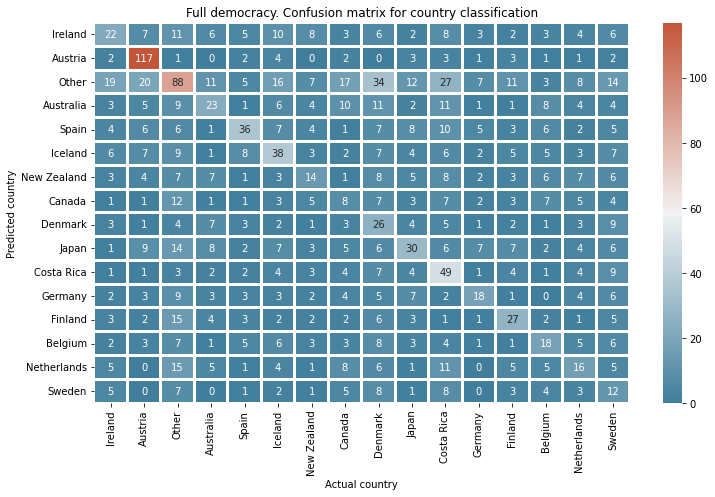

In [305]:
plot_conf_matrix_countries(labels, preds, categories)

In [306]:
regimes = sampled_data.outcome.unique().tolist()

Category: Authoritarian regime
Accuracy: 0.384
Category: Flawed democracy
Accuracy: 0.433
Category: Full democracy
Accuracy: 0.297
Category: Hybrid regime
Accuracy: 0.471


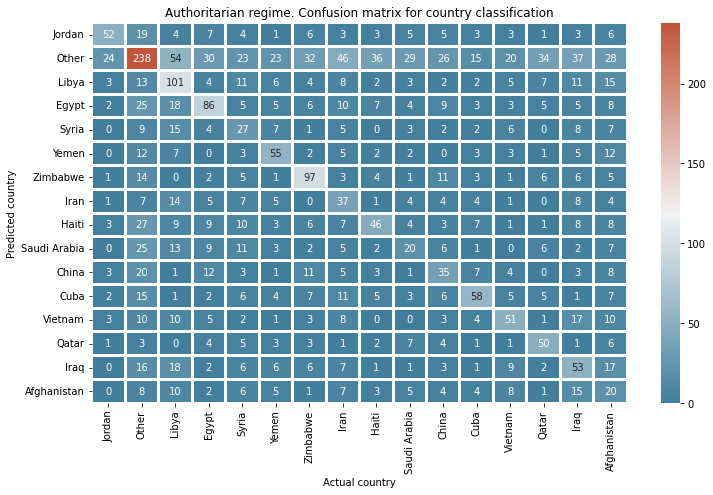

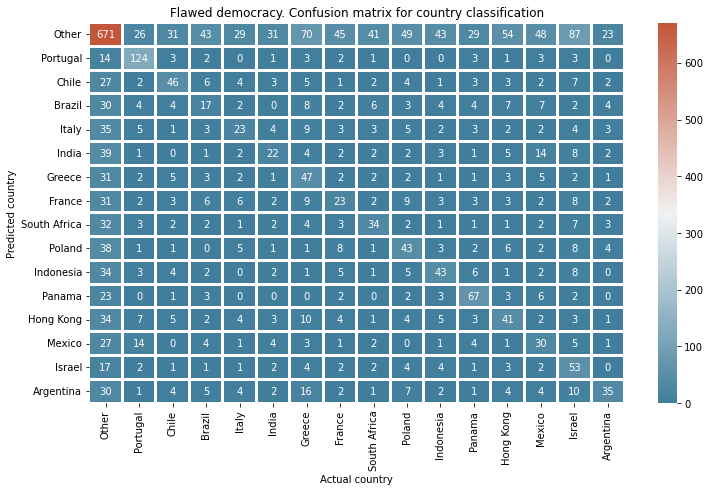

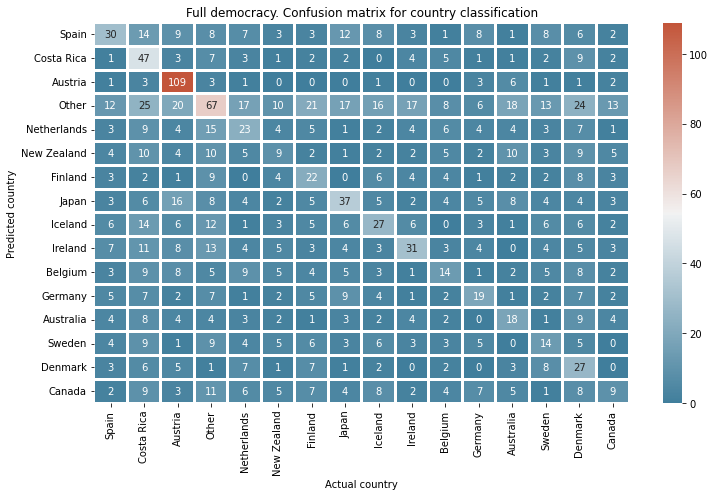

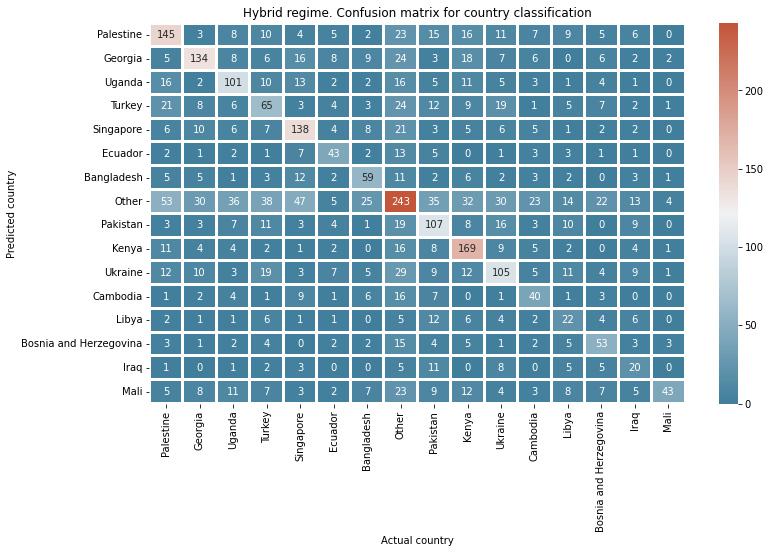

In [309]:
for c in regimes:
    print(f"Category: {c}")
    countries_top = get_top_countries(sampled_data, regime=c)
    train_data, test_data = filter_and_split(sampled_data, regime=c, to_display=False)

    # Get categories
    categories = train_data.outcome_country.unique().tolist()

    # Get total vocabulary
    total_vocab, vocab_dict = get_vocab(train_data, categories, 'outcome_country')

    # Get probability counts
    probs, counts = nb_c(vocab_dict, categories, delta=0.1)

    labels, preds = predict_bayes_countries(categories, test_data, 'outcome_country', probs)

    plot_conf_matrix_countries(labels, preds, categories, regime=c, savefig=True, name=f'conf_matrix_{c}_countries.png')

- Kenya -> Obama is a huge indicator since people believe he is from Kenya. 
- Georgia -> People talk about the state, not the country, so an issue (associated with state issues) 
- Ukraine -> Russian, crimea, war 
- Palestine -> palestinians, hamas 
- Uganda -> "kony", referring to Joseph Kony
- Austria has a high label because 'Austrian economics', austrian economic school, austrian economists, was dubbed as belong to the country 'Austria'.

# 6. Relationship between country classification and the variation in yearly frequency occurences

## 6.1. Get Naive Bayes for each country classification

In [36]:
def predict_bayes_all_probs(categories, test_countries, test_posts, probs):
    # Initialize lists for storing ground truth labels and predictions
    labels = []
    preds = []
    preds_all = []
    test_countries_output = []

    # Loop over categories
    for c_i in categories:

        # Loop over test posts
        for i, p in enumerate(test_posts[c_i]):

            # Store ground truth
            labels.append(c_i)

            # Calculate scores for categories
            scores = {'Full democracy': 0,
                      'Flawed democracy': 0,
                      'Hybrid regime': 0,
                      'Authoritarian regime': 0}

            for w in p:
                if w in probs[c_i]:
                    scores['Full democracy'] += np.log(probs['Full democracy'][w])
                    scores['Flawed democracy'] += np.log(probs['Flawed democracy'][w])
                    scores['Hybrid regime'] += np.log(probs['Hybrid regime'][w])
                    scores['Authoritarian regime'] += np.log(probs['Authoritarian regime'][w])


            # Use higher score for prediction
            preds.append(max(scores.items(), key=operator.itemgetter(1))[0])
            preds_all.append(dict(scores.items()))
            test_countries_output.append(test_countries[c_i][i])

    print('Accuracy: {:.3f}'.format(len([(l, p) for l, p in zip(labels, preds) if l == p]) / len(labels)))
    
    return labels, preds, preds_all, test_countries_output

In [767]:
len(test_posts['Authoritarian regime'])

3358

In [768]:
len(test_countries['Authoritarian regime'])

3358

In [769]:
d = 0.1

# Prepare training vocabularies
vocab_train = defaultdict(Counter)
for c_i in categories:
    vocab_train[c_i] = Counter({w: vocab_dict[c_i][w] for w in vocab_dict[c_i]})
    

In [47]:
country_df = pd.DataFrame({'labels': labels,
              'preds': preds,
             'countries': test_countries_output})

In [48]:
country_df.head()

,labels,preds,countries
0,Authoritarian regime,Authoritarian regime,"[Yemen, Vietnam]"
1,Authoritarian regime,Authoritarian regime,[Libya]
2,Authoritarian regime,Authoritarian regime,[Saudi Arabia]
3,Authoritarian regime,Authoritarian regime,"[Qatar, Saudi Arabia, Iran]"
4,Authoritarian regime,Full democracy,[Sudan]


## 6.2. Average prediction accuracy

In [49]:
# Calculate if the country prediction is true
country_df['pred_true'] = country_df.labels == country_df.preds

# Get a dataframe where each element inside the list becomes a row
rows = []
_ = country_df.apply(lambda row: [rows.append([row['labels'], row['preds'], nn]) 
                         for nn in row.countries], axis=1)
country_df2 = pd.DataFrame(rows, columns=country_df.columns[:-1])

In [52]:
country_df2['pred_true'] = country_df2.labels == country_df2.preds

In [53]:
# The mean is the % that are correct
# The sum is the total count of how many times it appeared
country_agg = country_df2.groupby('countries').agg({'pred_true': ['sum', 'mean']})['pred_true']

In [54]:
country_agg.columns = ['total_count', 'avg_prediction']
# Country mentioned at least 5 times
country_agg = country_agg[country_agg.total_count >= 5].copy()

# Get relative prediction accuracy (Relative to other countries, how much better or worse are they)
country_agg['relative_pred_acc'] = (country_agg['avg_prediction'] - country_agg['avg_prediction'].mean()) / country_agg['avg_prediction'].mean()

In [58]:
# Calculate the total number of times a country was mentioned, its average prediction, and relative prediction
country_agg.head()

,total_count,avg_prediction,relative_pred_acc
countries,,,
Afghanistan,237,0.887640,0.324589
Albania,18,0.692308,0.033102
Algeria,21,0.777778,0.160646
Angola,18,0.720000,0.074426
Argentina,86,0.577181,-0.138696


<AxesSubplot:>

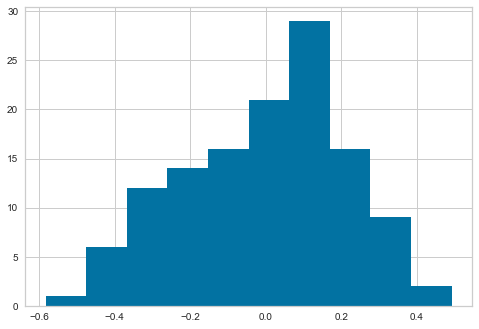

In [59]:
country_agg.relative_pred_acc.hist()

In [64]:
test_data['year'] =  test_data.date.str[:4]

In [65]:
# Calculate predictions on a yearly basis
years_dict = {}
for y in test_data.year.unique():
    years_dict[y] = test_data.loc[test_data.year == y, 'countries'].explode().value_counts()
    
years_df = pd.DataFrame(years_dict)

In [66]:
years_df.head()

,2012,2010,2011,2015,2013,2014
Afghanistan,34.0,153.0,29.0,14.0,22.0,15.0
Albania,9.0,6.0,1.0,3.0,5.0,2.0
Algeria,4.0,6.0,6.0,6.0,3.0,2.0
Angola,8.0,3.0,5.0,2.0,6.0,1.0
Argentina,36.0,13.0,34.0,17.0,34.0,15.0


## 6.3. Normalized Standard Deviation

In [67]:
# Calculate normalized standard deviation and merge back
years_df['normalized_std'] = years_df.std(axis=1) / years_df.mean(axis=1)
country_agg = country_agg.merge(years_df, left_index=True, right_index=True, how='left')

In [69]:
country_agg.head()

,total_count,avg_prediction,relative_pred_acc,2012,2010,2011,2015,2013,2014,normalized_std
countries,,,,,,,,,,
Afghanistan,237,0.887640,0.324589,34.0,153.0,29.0,14.0,22.0,15.0,1.207204
Albania,18,0.692308,0.033102,9.0,6.0,1.0,3.0,5.0,2.0,0.679366
Algeria,21,0.777778,0.160646,4.0,6.0,6.0,6.0,3.0,2.0,0.391263
Angola,18,0.720000,0.074426,8.0,3.0,5.0,2.0,6.0,1.0,0.633467
Argentina,86,0.577181,-0.138696,36.0,13.0,34.0,17.0,34.0,15.0,0.437736


## 6.4. Develop the plot

In [72]:

countries_show = ['Singapore', 'Iraq', 'Niger', 'Afghanistan', 'Bahrain', 
                  'Dominican Republic', 'Azerbaijan', 'Belarus', 'United States', 'Liby']

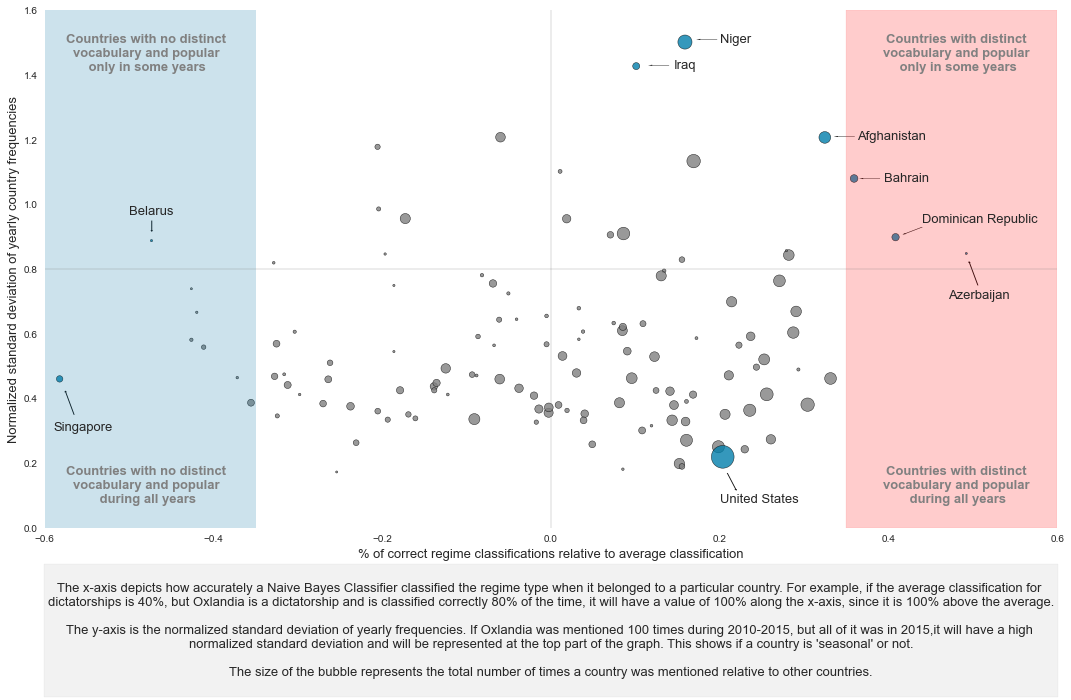

In [659]:
fig, ax = plt.subplots(1,1, figsize=(16,10))

# Set parameters
fontsize=13
linec = 'black'
linewidth=0.05

x = country_agg.relative_pred_acc
y = country_agg.normalized_std
size = [np.power(x,0.9) for x in country_agg.total_count]
countrylist = list(np.unique(country_agg.index))
colors = ['grey' if countrylist[x] not in countries_show else '#027fab' for x in range(len(countrylist))]

ax.scatter(x, y,s=size, c=colors, edgecolors='black', linewidth=0.5, alpha=0.8)

# Draw straight lines
ax.axvline(x=0, color='grey', linewidth=0.3)
ax.axhline(y=0.8, color='grey', linewidth=0.3)


#for i, txt in enumerate(countrylist):
#    if txt in countries_show:
#        ax.annotate(txt, (x[i], y[i]))
        
        
# Annotate the countries

# Singapore
ax.annotate('Singapore', (-0.59, 0.3), fontsize=fontsize)
ax.arrow(-0.565, 0.35, -0.01, 0.07, linewidth=linewidth, color='black')

# Azerbaijan
ax.annotate('Azerbaijan', (0.47, 0.71), fontsize=fontsize)
ax.arrow(0.506, 0.75, -0.01, 0.07, linewidth=linewidth, color='black')

# Afghanistan
ax.annotate('Afghanistan', (0.363, 1.2), fontsize=fontsize)
ax.arrow(0.360, 1.21, -0.02, 0, linewidth=linewidth, color='black')

# Bahrain
ax.annotate('Bahrain', (0.395, 1.070), fontsize=fontsize)
ax.arrow(0.39, 1.080, -0.02, 0, linewidth=linewidth, color='black')

# Dominican Republic
ax.annotate('Dominican Republic', (0.44, 0.945), fontsize=fontsize)
ax.arrow(0.44, 0.93, -0.02, -0.02, linewidth=linewidth, color='black')

# Iraq
ax.annotate('Iraq', (0.145, 1.42), fontsize=fontsize)
ax.arrow(0.14, 1.43, -0.02, 0, linewidth=linewidth, color='black')

# Niger
ax.annotate('Niger', (0.2, 1.5), fontsize=fontsize)
ax.arrow(0.197, 1.51, -0.02, 0, linewidth=linewidth, color='black')

# Belarus
ax.annotate('Belarus', (-0.5, 0.97), fontsize=fontsize)
ax.arrow(-0.473, 0.95, 0, -0.03, linewidth=linewidth, color='black')

# United states
ax.annotate('United States', (0.20, 0.08), fontsize=fontsize)
ax.arrow(0.209, 0.17, 0.01, -0.05, linewidth=linewidth, color='black')

ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylim((0,1.6))
ax.set_xlim(-0.6, 0.6)

# Set labels
ax.set_xlabel("% of correct regime classifications relative to average classification", fontsize=13)
ax.set_ylabel("Normalized standard deviation of yearly country frequencies", fontsize=13)

# Set explanations
ax.annotate('Countries with distinct\nvocabulary and popular\n only in some years', (0.48, 1.415), color='grey', weight='bold', fontsize=13, horizontalalignment='center')
ax.annotate('Countries with distinct\nvocabulary and popular\n during all years', (0.48, 0.08), color='grey', weight='bold', fontsize=13, horizontalalignment='center')
ax.annotate('Countries with no distinct\nvocabulary and popular\n only in some years', (-0.48, 1.415), color='grey', weight='bold', fontsize=13, horizontalalignment='center')
ax.annotate('Countries with no distinct\nvocabulary and popular\n during all years', (-0.48, 0.08), color='grey', weight='bold', fontsize=13, horizontalalignment='center')

# Set background of left and right
plt.axvspan(-0.6, -0.35, alpha=0.2)
plt.axvspan(0.6, 0.35, alpha=0.2, color='red')
txt = """
The x-axis depicts how accurately a Naive Bayes Classifier classified the regime type when it belonged to a particular country. For example, if the average classification for 
dictatorships is 40%, but Oxlandia is a dictatorship and is classified correctly 80% of the time, it will have a value of 100% along the x-axis, since it is 100% above the average.

The y-axis is the normalized standard deviation of yearly frequencies. If Oxlandia was mentioned 100 times during 2010-2015, but all of it was in 2015,it will have a high 
normalized standard deviation and will be represented at the top part of the graph. This shows if a country is 'seasonal' or not.

The size of the bubble represents the total number of times a country was mentioned relative to other countries.
"""
ax.text(0, -0.5, txt, ha='center',  size=13,
        bbox={'boxstyle': 'square', 'facecolor': 'grey', 'edgecolor': 'black', 'pad':0.3, 'alpha':0.1})
plt.tight_layout()
fig.savefig('pred_scatter3.png')

In [291]:
indices = [i for i, k in enumerate(x != y for x,y in zip(preds, labels)) if k]

# 7. Mutual Information

## 7.1. For each regime

In [122]:
def top_n(probs, n=30):
    return dict(sorted(probs.items(), key=operator.itemgetter(1), reverse=True)[:n])

In [124]:
keys = [x for x in probs['Hybrid regime']]
assert set(list(probs['Hybrid regime'].keys())) == set(list(probs['Full democracy'].keys()))

In [125]:
# Initialize data structures
vocab = defaultdict(Counter)
n_posts = defaultdict(Counter)

# Create vocabularies
for c_i in categories:
    for p in train_posts[c_i]:
        vocab[c_i].update(p)
        n_posts[c_i].update(set(p))

In [126]:
np.sum([x for x in n_posts['Hybrid regime'].values()])

378978

In [731]:
# Define a function for calculating MI between two categories
def mi_between_two_categories(w, c1, c2, n_posts, train_posts):

    # Get the number of posts of all categories
    count_c1 = len(train_posts[c1])
    count_c2 = len(train_posts[c2])

    # Get the n matrix
    n = np.array([[n_posts[c1][w], count_c1 - n_posts[c1][w]], [n_posts[c2][w], count_c2 - n_posts[c2][w]]])
    n = n / n.sum()
    
    return np.sum([n[i, j] * np.log2(n[i, j] / (n[i, :].sum() * n[:, j].sum())) for j in range(2) for i in range(2)])

In [730]:
# Define MI for one category vs another
def mi(w, count_c1, count_c2, c1, n_posts, train_posts, n_posts_sum):
    
    # Get the n matrix
    n = np.array([[n_posts[c1][w], count_c1 - n_posts[c1][w]], [n_posts_sum[w], count_c2 - n_posts_sum[w]]])
    n = n / n.sum()
    
    return np.sum([n[i, j] * np.log2(n[i, j] / (n[i, :].sum() * n[:, j].sum())) for j in range(2) for i in range(2)])

In [129]:
mi_score = {}
for c1 in categories:
    # get other category vocab
    vocab_c1 = set(vocab[c1])
    
    # Get the vocabulary of the rest of the words
    vocab_c2 = [set(vocab[c]) for c in categories if c != c1]
    vocab_c2 = set(chain.from_iterable(vocab_c2))

    # Get the number of posts of all categories
    count_c1 = len(train_posts[c1])
    count_c2 = np.sum([len(train_posts[c]) for c in categories if c != c1])
    
    # Get vocabulary intersections
    intersection_vocab = vocab_c1.intersection(vocab_c2)
    
    # Get the posts for all the other categories combined
    n_posts_sum = np.sum([n_posts[c] for c in categories if c != c1])
    
    # Calculate MI
    mi_f = sorted([(mi(w, count_c1, count_c2, c1, n_posts, train_posts, n_posts_sum), w) for w in intersection_vocab])
    mi_score[c1] = mi_f

In [130]:
mi_score.keys()

dict_keys(['Authoritarian regime', 'Flawed democracy', 'Full democracy', 'Hybrid regime'])

In [132]:
# Loop over categories and MI scores and calculate the top words
inf_words = {}
n = 100 # top words
for c1 in categories:
    inf_words[c1] = []
    for v, w in mi_score[c1][::-1][:n]:
    
        # Get the conditional probabilities of the word for the base category
        count_c1 = len(train_posts[c1])
        cond1 = n_posts[c1][w] / count_c1

        # Get the conditional probability of the word for the rest of the categories
        count_c2 = np.sum([len(train_posts[c]) for c in categories if c != c1])
        n_posts_sum = np.sum([n_posts[c] for c in categories if c != c1])
        cond2 = n_posts_sum[w] / count_c2

        if cond1 > cond2: inf_words[c1].append(w)

In [133]:
for c in categories:
    print(f"The top words for the category {c} are: ", inf_words[c])
    print()

The top words for the category Authoritarian regime are:  ['war', 'al', 'saddam', 'troops', 'oil', 'rebels', 'military', 'wars', 'michael', 'saudi', 'bush', 'jazeera', 'obama', 'saudis', 'clinton', 'qaeda', 'darfur', 'assad', 'gaddafi', '911', 'bomb', 'taliban', 'mubarak', 'isis', 'weapons', 'regime', 'air', 'embargo', 'alqaeda', 'gulf', 'civilians', 'combat', 'protesters', 'castro', 'earthquake', 'genocide', 'gitmo', 'guantanamo', 'chemical', 'dictator', 'administration']

The top words for the category Flawed democracy are:  ['apartheid', 'canal', 'drugs', 'drug', 'decriminalized', 'republic', 'pinochet', 'viagra', 'decriminalization', 'mccain', 'heroin', 'austerity', 'cartels', 'born', 'polish', 'addiction', 'addicts', 'legalization', 'mexican', 'italian', 'legalized', 'prostitutes', 'boys', 'sanford', 'prohibition', 'mandela', 'allende', 'users', 'potato', 'mistress', 'cocaine', 'czech', 'friedman', 'underage', 'decriminalize', 'chinese', 'illegal', 'falklands', 'portuguese', 'milt

In [146]:
for c in categories:
    inf_words[c] = inf_words[c][:30]

In [194]:
pd.DataFrame(inf_words)

,Authoritarian regime,Flawed democracy,Full democracy,Hybrid regime
0,war,apartheid,countries,obama
1,al,canal,higher,muslim
2,saddam,drugs,economics,sniper
3,troops,drug,europe,putin
4,oil,decriminalized,rate,sasha
5,rebels,republic,healthcare,gays
6,military,pinochet,health,crimea
7,wars,viagra,education,embassy
8,michael,decriminalization,rates,kony
9,saudi,mccain,tax,turkish


In [145]:
with open('mi_words.tex', 'w') as tf:
     tf.write(pd.DataFrame(inf_words).to_latex(index=False))

## 7.2. For a country within the regime

### 7.2.1. Extracting MI

In [723]:
country_posts = {}

for c in regimes:
    country_posts[c] = {}
    
    # Get data (need to fix the data frame to ensure that the right countries are represented in the final model)
    temp_data = train_data.loc[train_data.outcome == c].copy()
    countrylist = temp_data.countries.explode().unique()
    for country in countrylist:
        country_posts[c][country] = []
        for ls in temp_data.loc[temp_data.countries.map(lambda x: country in x), 'tokens']:
            country_posts[c][country].append(ls)

In [733]:
def extract_mi_country(reg):
    """Extracts mutual information for each country
    for the given regime. Returns the mutual info scors"""
    
    # Extract countrylist
    countrylist = train_data.loc[train_data.outcome == reg, 'countries'].explode().unique()

    
    # Initialize data structures
    vocab_c = defaultdict(Counter)
    n_posts_c = defaultdict(Counter)

    # Create vocabularies
    for c_i in countrylist:
        for p in country_posts[reg][c_i]:
            vocab_c[c_i].update(p)
            n_posts_c[c_i].update(set(p))
            
            
    # Calculate MI Scores
    mi_score_c = {}

    for c1 in countrylist:
        # get other category vocab
        vocab_c1 = set(vocab_c[c1])

        # Get the vocabulary of the rest of the words
        vocab_c2 = [set(vocab_c[c]) for c in countrylist if c != c1]
        vocab_c2 = set(chain.from_iterable(vocab_c2))

        # Get the number of posts of all categories
        count_c1 = len(country_posts[reg][c1])
        count_c2 = np.sum([len(country_posts[reg][c]) for c in countrylist if c != c1])

        # Get vocabulary intersections
        intersection_vocab = vocab_c1.intersection(vocab_c2)

        # Get the posts for all the other categories combined
        n_posts_sum = np.sum([n_posts_c[c] for c in countrylist if c != c1])

        # Calculate MI
        mi_f = sorted([(mi(w, count_c1, count_c2, c1, n_posts_c, train_posts[reg], n_posts_sum), w) for w in intersection_vocab])
        mi_score_c[c1] = mi_f
    
    return mi_score_c, n_posts_c

In [734]:
def get_top_mi_per_country(mi_scores_c, n_posts_c, reg,  n=5):
    """Gets the top 5 words for each country based on the
    probabilities for each word"""
    
    countrylist = train_data.loc[train_data.outcome == reg, 'countries'].explode().unique()
    
    inf_words = {}
    
    for c1 in countrylist:
        inf_words[c1] = []
        for v, w in mi_score_c[c1][::-1][:n]:

            # Get the conditional probabilities of the word for the base category
            count_c1 = len(country_posts[reg][c1])
            cond1 = n_posts_c[c1][w] / count_c1

            # Get the conditional probability of the word for the rest of the categories
            count_c2 = np.sum([len(country_posts[reg][c]) for c in countrylist if c != c1])
            n_posts_sum = np.sum([n_posts_c[c] for c in countrylist if c != c1])
            cond2 = n_posts_sum[w] / count_c2

            if cond1 > cond2: inf_words[c1].append(w)
    words_regime = {k:v for k,v in inf_words.items()}
    
    return words_regime

In [737]:
for reg in regimes:
    print(f"Extracting mutual information for {reg}")
    # Get MI scores
    print("Getting mutual information scores")
    mi_score_c, n_posts_c = extract_mi_country(reg)
    
    
    print("Assigning them to specific words")
    # Get MI scores specific to that country
    words_regime = get_top_mi_per_country(mi_score_c, n_posts_c, reg)
    
    # Export to JSON
    with open(f'regime_{reg}.json', 'w') as fp:
        json.dump(words_regime, fp)

Extracting mutual information for Full democracy
Getting mutual information scores


<ipython-input-730-3691ec16ed2e>:7: RuntimeWarning: divide by zero encountered in log2
  return np.sum([n[i, j] * np.log2(n[i, j] / (n[i, :].sum() * n[:, j].sum())) for j in range(2) for i in range(2)])
<ipython-input-730-3691ec16ed2e>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum([n[i, j] * np.log2(n[i, j] / (n[i, :].sum() * n[:, j].sum())) for j in range(2) for i in range(2)])


Assigning them to specific words
Extracting mutual information for Flawed democracy
Getting mutual information scores
Assigning them to specific words
Extracting mutual information for Hybrid regime
Getting mutual information scores
Assigning them to specific words
Extracting mutual information for Authoritarian regime
Getting mutual information scores
Assigning them to specific words


In [754]:
with open('regime_Authoritarian regime.json') as json_file:
    auth = json.load(json_file)

In [755]:
topwords = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in auth.items() ])).transpose()
topwords.columns = [f'top_word_{x}' for x in range(1,6)]

In [756]:
# Top words for some of the countries
topwords.head()

,top_word_1,top_word_2,top_word_3,top_word_4,top_word_5
Democratic Republic of the Congo,republic,democratic,rape,belgian,dr
Iraq,war,bush,troops,wars,invasion
Chad,hanging,taylor,henderson,named,NaN
China,chinese,communist,market,trade,NaN
Bahrain,protesters,cnn,lyon,amber,documentary


### 7.2.2. Plotting MI

In [761]:
# Mutual information - top 5 words for all the countries relative to other countries in that regime
for r in regimes:
    
    # Import regime file
    with open(f'regime_{r}.json') as json_file:
        auth = json.load(json_file)
        
    topwords = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in auth.items() ])).transpose()
    topwords.columns = [f'top_word_{x}' for x in range(1,6)]
    
    # Export to Latex
    print(f"REGIME: {r}")
    display(topwords)
    with open(f'reg_mi_{i}_{r}.tex', 'w') as tf:
         tf.write(topwords.to_latex(index=False))


REGIME: Full democracy


,top_word_1,top_word_2,top_word_3,top_word_4,top_word_5
Germany,nazi,german,hitler,nazis,germans
Denmark,danish,danes,dane,socialism,sanders
United States,people,dont,make,just,going
Norway,oil,norwegian,countries,socialism,norwegians
Canada,canadian,care,canadians,health,healthcare
Sweden,swedish,socialism,assange,socialist,countries
Iceland,banks,bankers,collapse,fail,medieval
United Kingdom,intergenerational,exceptionalism,britain,earnings,british
Finland,education,teachers,finnish,schools,teaching
Netherlands,dutch,amsterdam,marijuana,weed,euthanasia


REGIME: Flawed democracy


,top_word_1,top_word_2,top_word_3,top_word_4,top_word_5
Singapore,healthcare,controls,systems,price,market
South Africa,apartheid,black,mandela,blacks,white
Indonesia,muslim,obama,hawaii,islam,muslims
Israel,palestinians,jews,jewish,palestinian,apartheid
Philippines,filipino,marcos,manila,typhoon,semiskilled
Greece,debt,austerity,spending,ancient,greek
Chile,pinochet,friedman,allende,milton,coup
Brazil,movie,oil,radiation,paulo,forest
Thailand,carrier,thai,aircraft,vacation,publishers
Bulgaria,european,borders,1942,communist,ac


REGIME: Hybrid regime


,top_word_1,top_word_2,top_word_3,top_word_4,top_word_5
Pakistan,drone,bin,strikes,laden,drones
Kenya,obama,muslim,born,socialist,communist
Turkey,turkish,kurds,secular,kurdish,thanksgiving
Bosnia and Herzegovina,sniper,clinton,hillary,kosovo,war
Armenia,genocide,turks,holocaust,turkish,ottoman
Honduras,coup,zelaya,honduran,immigration,fleeing
Mali,sasha,malice,malicious,intent,tashfeen
Palestine,palestinians,jews,jewish,palestinian,land
Cambodia,pol,khmer,rouge,nixon,pot
Ecuador,assange,chevron,embassy,asylum,snowden


REGIME: Authoritarian regime


,top_word_1,top_word_2,top_word_3,top_word_4,top_word_5
Democratic Republic of the Congo,republic,democratic,rape,belgian,dr
Iraq,war,bush,troops,wars,invasion
Chad,hanging,taylor,henderson,named,NaN
China,chinese,communist,market,trade,NaN
Bahrain,protesters,cnn,lyon,amber,documentary
Iran,nuclear,deal,sanctions,romney,shah
Saudi Arabia,saudi,oil,women,religious,islam
Libya,obama,benghazi,rebels,nato,gaddafi
Niger,cheney,prince,shell,scam,charges
Nigeria,prince,cheney,shell,bribery,scam


In [243]:
words_regime.columns = [f'Top {x} word' for x in range (1,6)]
words_regime.to_csv(f"Top 5 words {reg}.csv")

# 8. LSTM Classifier

## 8.1. Building the classifier

In [310]:
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [311]:
stopwords = get_stopwords()

In [334]:
# Load the data
sampled_data = load_sample_data()
sampled_data = mask_country(sampled_data)

In [335]:
categories = ['Full democracy', 'Flawed democracy', 'Hybrid regime', 'Authoritarian regime']
outcome2label = {c: l for l, c in enumerate(categories)}
label2outcome = {k[1]:k[0] for k in outcome2label.items()}

In [336]:
sampled_data['labels'] = sampled_data['outcome'].map(outcome2label)
sampled_data['tokens'] = sampled_data['tokens'].map(lambda ls: [x for x in ls if x != '[MASK]'])

In [338]:
train, dev_test = train_test_split(sampled_data, test_size=0.2, stratify=sampled_data['outcome'], random_state=42)
dev, test = train_test_split(dev_test, test_size=0.5, stratify=dev_test['outcome'], random_state=42)

In [340]:
train.outcome.value_counts()

Flawed democracy        13431
Authoritarian regime    13430
Hybrid regime           13430
Full democracy          13430
Name: outcome, dtype: int64

In [135]:
train.labels.value_counts()

1    13431
0    13430
2    13430
3    13430
Name: labels, dtype: int64

In [341]:
# Get word counter
word_counter = Counter([w for a in train.tokens for w in a])
w2id = {w: i + 2 for i, w in enumerate(w for w, c in word_counter.most_common())}

# Create dictionary for reverse word look-up
id2w = {i:w for w, i in w2id.items()}

In [342]:
class LSTMDataset(Dataset):
    
    def __init__(self, data, w2id):
        
        # Encode the words
        self.posts = list(data.tokens.apply(lambda x: [w2id[w] if w in w2id else 1 for w in x]))
        
        # Store the outcome variables
        self.labels = list(data.labels)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        comment = self.posts[idx]
        label = self.labels[idx]
        
        return comment, label

In [343]:
def lstm_collate(batch):
    
    # Store the batch size
    batch_size = len(batch)
    
    # Separate comments and labels
    posts = [a for a, _ in batch]
    labels = torch.tensor([l for _, l in batch]).long()
    
    # Store length of longest comment in batch
    max_len = max(len(a) for a in posts)
    
    # Create padded tensors
    posts_pad = torch.zeros((batch_size, max_len)).long()
    for i, a in enumerate(posts):
        posts_pad[i, :len(a)] = torch.tensor(a)
        
    return posts_pad, labels

In [344]:
class LSTMClassifier(nn.Module):
    
    def __init__(self, pretrained_embed, hidden_dim, output_dim):
        
        # Define network layers
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embed, padding_idx=0)
        self.lstm = nn.LSTM(pretrained_embed.shape[1], hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        
        # Define dropout
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, posts):
        
        # Define flow
        emb = self.embedding(posts)
        output, (hidden, cell) = self.lstm(self.dropout(emb))
        return self.linear(self.dropout(output[:, -1, :]))

In [372]:
# Create datasets
train_dataset = LSTMDataset(train, w2id)
dev_dataset = LSTMDataset(dev, w2id)
test_dataset = LSTMDataset(test, w2id)

In [373]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=100, collate_fn=lstm_collate, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=100, collate_fn=lstm_collate)
test_loader = DataLoader(test_dataset, batch_size=100, collate_fn=lstm_collate)

In [ ]:
ft = fasttext.load_model('cc.en.300.bin')

In [377]:
# Create matrix of pretrained embeddings

fasttext_emb = torch.tensor([ft.get_word_vector(id2w[i]) for i in range(2, len(id2w) + 2)]).float()
fasttext_emb = torch.cat((torch.zeros((1, 300)), fasttext_emb.mean(axis=0, keepdim=True), fasttext_emb), axis=0)

In [378]:
with open('fattext_emb.pickle', 'wb') as f:
    pickle.dump(fasttext_emb, f)

In [379]:
# Initialize model
model = LSTMClassifier(fasttext_emb, 200, 4)

# Define optimizer and training objective
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Define device and move model to CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [382]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)

## 8.2. Running the model

In [ ]:
# Train model
for e in range(1, 45):
    
    running_loss = 0
    correct = 0
    total = 0

    model.train()

    for i, b in enumerate(train_loader):
        
        # Get data and target
        data_, target_ = [t.to(device) for t in b]  

        # Perform forward pass
        optimizer.zero_grad()

        output = model(data_)
        loss = criterion(output, target_)
        
        # Perform backpropagation and update weights
        loss.backward()
        optimizer.step()
        
        # Get statistics
        running_loss += loss.item()
        _, pred = torch.max(output, dim=1)

        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        
    
    # Append statitics
    train_acc.append(100*correct/total)
    train_loss.append(running_loss/total_step)
    
    # Batch loss
    batch_loss = 0
    total_t = 0
    correct_t = 0
    
    # Evaluate model on development data
    model.eval()

    y_true = list()
    y_pred = list()

    with torch.no_grad():
        for b in dev_loader:
            
            # Get data
            data_t, target_t = [t.to(device) for t in b]            
            output_t = model(data_t)
            
            # Get loss
            loss_t = criterion(output_t, target_t)
            batch_loss += loss_t.item()
            _, pred_t = torch.max(output_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
            
            y_true.extend(target_t.tolist())
            y_pred.extend(pred_t.tolist())
            
        val_acc.append(100*correct_t/total_t)
        val_loss.append(batch_loss/len(dev_loader))
        
      # Save the model
    print(y_pred)
    if e % 10 == 0:
        torch.save(model.state_dict(), f'./model/model_{e}.pth')

    print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')

In [ ]:
def plot_loss(train_loss, val_loss, savefig=False):
    fig = plt.figure(figsize=(20,10))
    plt.title("Train - Validation Loss")
    plt.plot( train_loss, label='train')
    plt.plot( val_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    if savefig: fig.savefig('lstm_loss.png')
    
    
def plot_accuracy(train_acc, val_acc, savefig=False):
    fig = plt.figure(figsize=(20,10))
    plt.title("Train - Validation Accuracy")
    plt.plot(train_acc, label='train')
    plt.plot(val_acc, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    plt.legend(loc='best')
    if savefig: fig.savefig('lstm_acc.png')

## 8.3. Importing results from Google Colab

In [312]:
lstm = pd.read_json(f'.{os.sep}LSTM log{os.sep}results_dump_02_001_onedirectional.json')

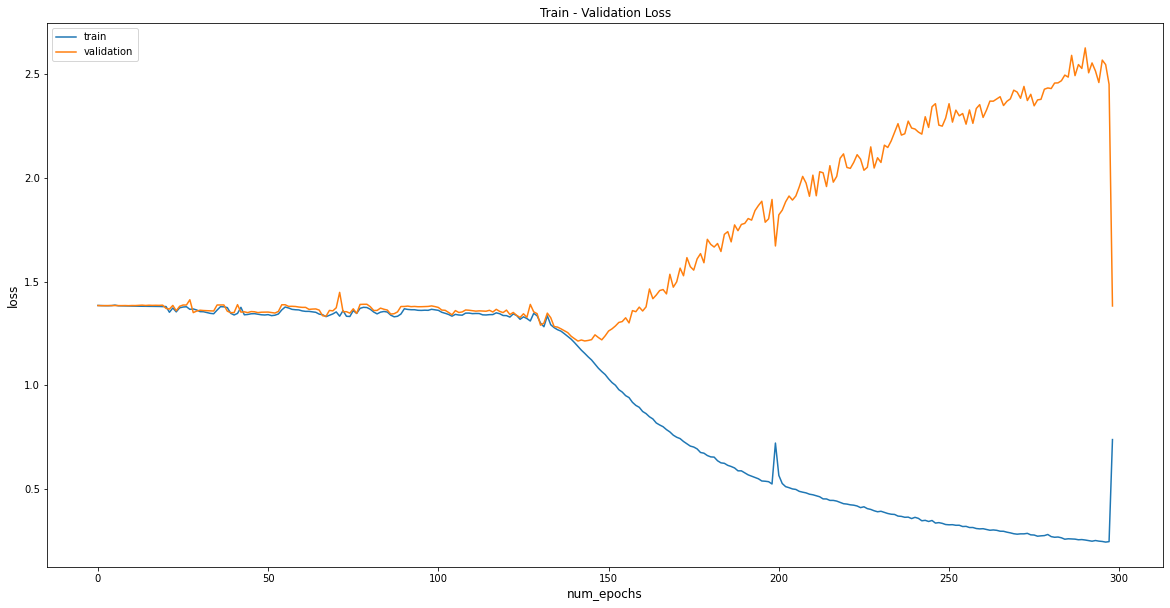

In [323]:
plot_loss(lstm.tl, lstm.vl, savefig=True)

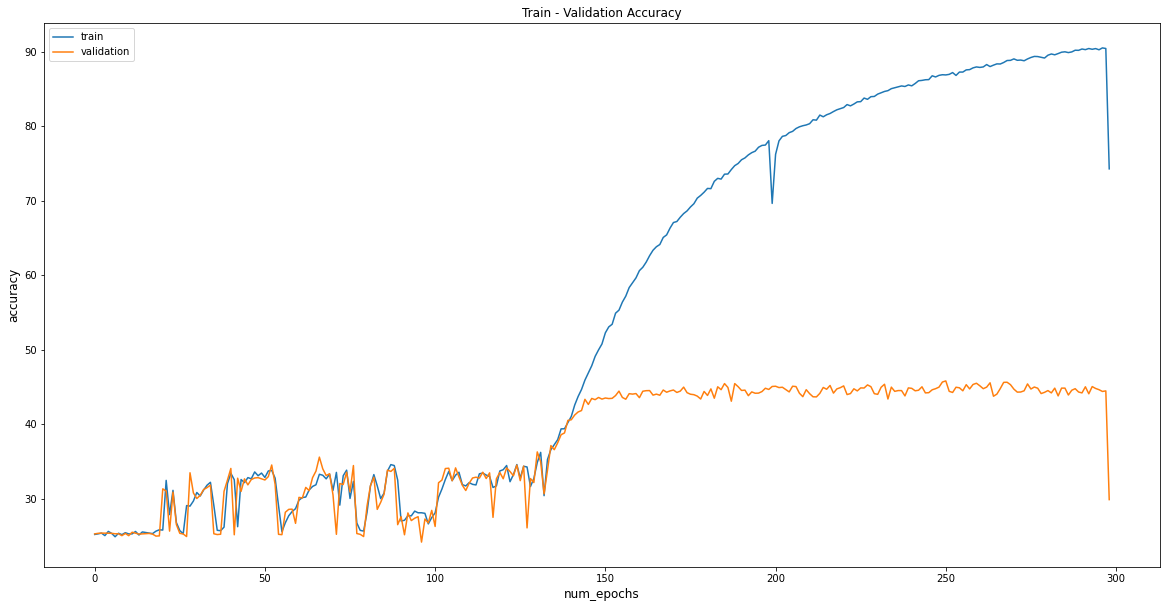

In [324]:
plot_accuracy(lstm.ta, lstm.va, savefig=True)

# 9. Topic modelling using clustering of embeddings

1. Get all the words in the document
2. Get their frequencies
3. Map the words to embeddings
4. Go over k-means clusering with weighting
5. Extract centroids and words within each centroid
6. Get words in each topic
7. Rerank based on frequency

## 9.1. Cleaning data for topic modelling

### 9.1.1. Removing masks and numbers

In [327]:
def remove_mask_numbers(ls):
    """Remove the mask token and the numbers"""
    
    no_numbers = [x for x in ls if not (x.isdigit() or x in '-+.')]
    no_mask = [x for x in no_numbers if '[MASK]' not in x]
    
    return no_mask

In [328]:
def unit_test_numbers():
    """Test that the removal of numbers works well"""
    
    numbers = ['12', '12', '123110']
    no_numbers = ['hope', 'you', 'enjoy', 'my', 'summative']
    
    numbers_ed = remove_mask_numbers(numbers)
    no_numbers_ed = remove_mask_numbers(no_numbers)
    
    assert len(numbers_ed) == 0
    assert len(no_numbers_ed) == len(no_numbers)

In [329]:
sampled_data['tokens'] = sampled_data.tokens.map(remove_mask_numbers)

In [330]:
unit_test_numbers()

### 9.1.2. Removing words that appear in less than 5 documents

In [361]:
remove_words = set([k for k, v in sampled_data.tokens.explode().value_counts().items() if v <= 5])

In [366]:
%timeit sampled_data.sample(1000)['tokens'].map(lambda ls: [x for x in ls if x not in remove_words])

12.8 ms ± 2.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [371]:
sampled_data['tokens_cleaned'] = sampled_data['tokens'].map(lambda ls: [x for x in ls if x not in remove_words])

### 9.1.3. Extracting year and regime specific data

In [334]:
sampled_data['year'] = sampled_data['date'].map(lambda dt: int(str(dt)[:4]))

In [335]:
auth2010 = sampled_data[(sampled_data['outcome'] == 'Authoritarian regime') & (sampled_data['year'] == 2010)]

In [378]:
sampled_data['tokens_cleaned'].explode().unique().__len__()

20847

## 9.2. Building the topic modelling mechanism

In [388]:
def get_topic_inputs(df):
    """Extracts the X vector from fasttext embeddings, 
    word frequency, and vocabulary"""
    # Get documents and words frequency
    documents = df['tokens_cleaned'].tolist()

    word_freq = pd.Series(documents).explode().value_counts()
    X = np.array([ft.get_word_vector(x) for x in word_freq.index])

    # Get vocabulary
    vocab = word_freq.index.tolist()
    
    return word_freq, X, vocab

In [340]:
word_freq, X, vocab = get_topic_inputs(auth2010)

In [802]:
k = 10

In [803]:
kmeans = KMeans(n_clusters=k, n_init=20, max_iter=1000)
kmeans.fit(X, sample_weight=word_freq.values)
labels = kmeans.labels_
sscore = silhouette_score(X, labels)

In [395]:
def get_silhouette_scores(X, words_freq, k1, k2, n_jobs=1):
    """Calculate silhouette scores for the given k1 to k2 cluster ranges"""
    s_scores = {}
    for k in range(k1, k2):
        kmeans = KMeans(n_clusters=k, n_init=10, max_iter=1000, n_jobs=n_jobs)
        kmeans.fit(X, sample_weight=word_freq.values)
        labels = kmeans.labels_
        sscore = silhouette_score(X, labels)
        s_scores[k] = sscore
    return s_scores

In [ ]:
s_scores = get_silhouette_scores(X, words_freq, 2, 8)

In [342]:
def get_cluster_topics(k, X, word_freq):
    """Get the cluster and key words mentioned within each cluster, ranked by
    their overall frequency"""

    # Initialize KMeans
    kmeans = KMeans(n_clusters=k)
    
    # Get labels
    kmeans.fit(X, sample_weight=word_freq.values)
    labels = kmeans.labels_
    
    # Get labels and vocab
    unique_labels = np.unique(labels)
    vocab = word_freq.index.tolist()

    # Get IDs
    ids = {w: c for w, c in zip(vocab, labels)}
    
    # Get all words within each category cluster
    categories = {}
    for l in unique_labels:
        categories[l] = pd.Series(vocab)[labels == l].values

    # For each category, rank the words based on their frequency
    for ind in categories: 
        categories[ind] = Counter({w:word_freq[w] for w in categories[ind]})
        
    return categories

In [806]:
categories = get_cluster_topics(4, X, word_freq)

In [680]:
def plot_sil_scores(p1, p2, k1, k2):
    fig, ax = plt.subplots(p1, p2, figsize=(15,8))

    for k in range(k1, k2):
        kmeans = KMeans(n_clusters=k)
        q, mod = divmod(k, 2)

        visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick', ax=ax[q-1][mod])
        visualizer.fit(np.array(X))

        # Calculate silhouette score
        score_ = np.round(float(visualizer.silhouette_score_), 2)
        ax[q-1][mod].set_title(f"Using {k} clusters, silhouette score: {score_}")


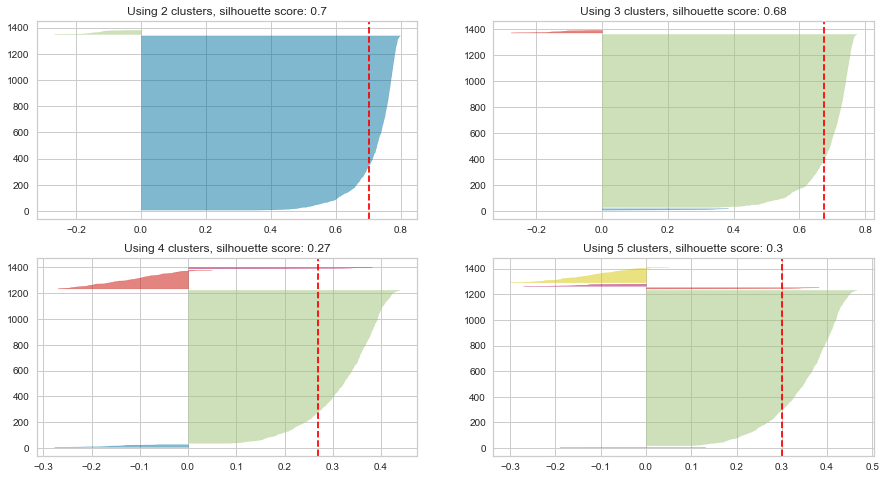

In [681]:
plot_sil_scores(2,2,2,6)

## 9.3. Calculating the best cluster value

In [382]:
outcome_labels = sampled_data.outcome.unique().tolist()

In [ ]:
# Get the k to loop over
k1 = 5
k2 = 25
scores_regimes = {}
for regime in outcome_labels:
    print(f"Regime: {regime}")
    regime2010df = sampled_data[(sampled_data['outcome'] == regime) & (sampled_data['year'] == 2010)]
    word_freq, X, vocab = get_topic_inputs(regime2010df)
    s_scores = get_silhouette_scores(X, word_freq, k1, k2, n_jobs=-1)
    
    scores_regimes[regime] = s_scores

In [398]:
scores_dumps = json.dumps(str(scores_regimes))
with open('./topic_model/results_all_regimes2.json', 'w') as f:
    f.write(scores_dumps)

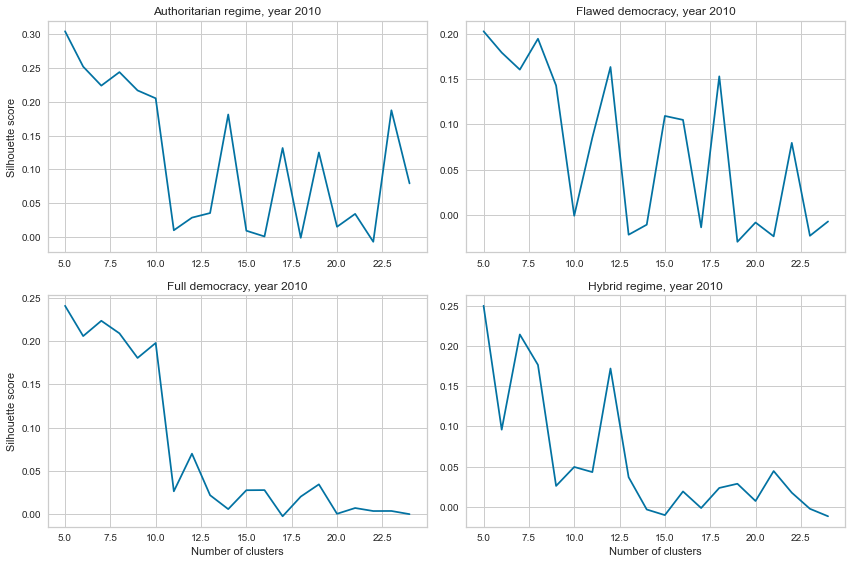

In [399]:
fig, axs = plt.subplots(2,2, figsize=(12,8))

axs_list = axs.flatten()
for i, regime in enumerate(outcome_labels):
    data_reg = scores_regimes[regime]
    ax = axs_list[i]
    ax.plot(data_reg.keys(), data_reg.values())
    ax.set_title(f"{regime}, year 2010")
    
    if i > 1: ax.set_xlabel("Number of clusters")
    if i in [0,2]: ax.set_ylabel("Silhouette score")

plt.tight_layout()
fig.savefig('Silhouette scores.png')

In [381]:
def get_silhouette_scores_selected(X, words_freq, k_ls, n_jobs=1):
    """Calculate silhouette scores for the given list of inputs"""
    s_scores = {}
    for k in k_ls:
        kmeans = KMeans(n_clusters=k, n_init=10, max_iter=1000, n_jobs=n_jobs)
        kmeans.fit(X, sample_weight=word_freq.values)
        labels = kmeans.labels_
        sscore = silhouette_score(X, labels)
        s_scores[k] = sscore
    return s_scores

In [ ]:
# Loop over regimes and get the silhouettes scores
k_ls = [50, 70, 100, 120, 150, 200]
scores_adj = {}
for regime in outcome_labels:
    print(f"Regime: {regime}")
    regime2010df = sampled_data[(sampled_data['outcome'] == regime) & (sampled_data['year'] == 2010)]
    word_freq, X, vocab = get_topic_inputs(regime2010df)
    s_scores = get_silhouette_scores_selected(X, word_freq, k_ls, n_jobs=-1)
    print(s_scores)
    
    scores_adj[regime] = s_scores

## 9.4. Topics through time

1. Choose the number of clusters [based on literature too]
2. Compute the clusters for the year 2010 for all democracies and dictatorships
3. Label the clusters
4. Rerun for the other years (2010 -> 2015)
5. See how the topics change
6. Plot the topics

In [ ]:
# Select the k and get silhouette scores for all outcome labels
k = 10
for regime in outcome_labels:
    print(f"Regime: {regime}")
    regime2010df = sampled_data[(sampled_data['outcome'] == regime) & (sampled_data['year'] == 2010)]
    word_freq, X, vocab = get_topic_inputs(regime2010df)
    s_scores = get_silhouette_scores_selected(X, words_freq, k_ls, n_jobs=-1)
    
    scores_adj[regime] = s_scores

In [500]:
# Define a function to get the topics
def get_category_topics(labels, word_freq):
        # Get labels and vocab
    unique_labels = np.unique(labels)
    vocab = word_freq.index.tolist()

    # Get IDs
    ids = {w: c for w, c in zip(vocab, labels)}

    # Get all words within each category cluster
    categories = {}
    for l in unique_labels:
        categories[l] = pd.Series(vocab)[labels == l].values

    # For each category, rank the words based on their frequency
    for ind in categories: 
        categories[ind] = Counter({w:word_freq[w] for w in categories[ind]})
    
    return categories

In [ ]:
# Get mapping for the number of clusters within each regime, based on the silhouette scores
regime_to_cluster = {'Authoritarian regime': 10,
                     'Hybrid regime': 12,
                     'Flawed democracy': 12,
                     'Full democracy': 10}

# Loop over the years and regimes
for regime in regime_to_cluster.keys():
    
    for year in range(2010,2016):
        
        k = regime_to_cluster[regime]
        
        # Initialize KMeans. If 2010, do it randomly. Otherwise, start with the preivous centroids
        if year != 2010:
            kmeans = KMeans(n_clusters=k, init=centroid_location)
        else:
            kmeans = KMeans(n_clusters=k)

        regime_df = sampled_data[(sampled_data['outcome'] == regime) & (sampled_data['year'] == year)]
        word_freq, X, vocab = get_topic_inputs(regime_df)

        # Get labels
        kmeans.fit(X, sample_weight=word_freq.values)
        labels = kmeans.labels_
        centroid_location = kmeans.cluster_centers_

        #Get topic categories
        categories = get_category_topics(labels, word_freq)

        categories_str = str(categories)
        with open(f'./topic_model/{regime}_{year}.json', 'w') as f:
            f.write(categories_str)


Fitting for 2011

In [491]:
regime = 'Full democracy'

regime2015df = sampled_data[(sampled_data['outcome'] == regime) & (sampled_data['year'] == 2015)]
word_freq, X, vocab = get_topic_inputs(regime2015df)

In [494]:
# Initialize KMeans
kmeans = KMeans(n_clusters=10, init=centers)

In [ ]:
# Get labels
kmeans.fit(X, sample_weight=word_freq.values)
labels = kmeans.labels_


In [496]:
# Get labels and vocab
unique_labels = np.unique(labels)
vocab = word_freq.index.tolist()

# Get IDs
ids = {w: c for w, c in zip(vocab, labels)}

# Get all words within each category cluster
categories = {}
for l in unique_labels:
    categories[l] = pd.Series(vocab)[labels == l].values

# For each category, rank the words based on their frequency
for ind in categories: 
    categories[ind] = Counter({w:word_freq[w] for w in categories[ind]})


In [ ]:
kmeans = KMeans(n_clusters=k, max_iter=1000, init = )
kmeans.fit(X, sample_weight=word_freq.values)
labels = kmeans.labels_
sscore = silhouette_score(X, labels)

## 9.5. Exporting to Latex

In [517]:
topicsum = pd.read_excel('./topic_model/topics_summary.xlsx')

In [523]:
for reg in regimes:
    tp = topicsum.loc[topicsum.Regime == reg, ['Interpretation', 'Words', 'Regime']]
    tp['Words'] = tp['Words'].str.replace("’", "")
    display(f"Regime: {reg}")
    display(tp)
    print()
    with open(f'topics_{reg}.tex', 'w') as tf:
         tf.write(tp.to_latex(index=False, escape=True))

'Regime: Authoritarian regime'

,Interpretation,Words,Regime
0,Leaders,"Obama, Saddam, Cheney, Muslim, Clinton, God, J...",Authoritarian regime
1,Economics / tax,"Tax, law, free, levy",Authoritarian regime
2,General,"just, like, dont, think",Authoritarian regime
3,War,"war, wars, ww2",Authoritarian regime
4,General,"right, going, money, time, really, way, good",Authoritarian regime
5,International Relations / World,"people, government, said, world, military, tro...",Authoritarian regime


'Regime: Flawed democracy'

,Interpretation,Words,Regime
14,General,"white, black, oil, water, food, head, face",Flawed democracy
15,Opinions and expressions,just like dont think how did,Flawed democracy
16,International and local affairs,"government, world, state, countries, hustory, ...",Flawed democracy
17,Adjectives,"good, lot, great, old, pretty",Flawed democracy
18,European Union,EU,Flawed democracy
19,"Discussion, argumentation","people, really, said, actually, thinkg, things...",Flawed democracy
20,Economics,"Money, care, law, pay, tax, land, oil",Flawed democracy
21,Daily life and change,"Time, make, right, way, years, going, work, live",Flawed democracy
22,War and ethnicities,"War, jews, obama, muslim, europe, french, jewi...",Flawed democracy
23,Vulgar expressions and slang,"yes, shit, fuck, guy, yeah",Flawed democracy


'Regime: Full democracy'

,Interpretation,Words,Regime
24,War,"war, wars, ww2, ww1",Full democracy
25,EU,"Id, eu",Full democracy
26,Economics,"tax, law, taxes, laws, oil, gun, debt, guns",Full democracy
27,International affairs,"people, government, health, countries, world, ...",Full democracy
28,Daily conversations,"care, make, way, time, right, going, money, work",Full democracy
29,Europe,"Europe, european, gdp, british, britain, english",Full democracy
30,Titles,"Mr, Dr",Full democracy
31,General,"Like, just, dont, think, know, really, want, g...",Full democracy


'Regime: Hybrid regime'

,Interpretation,Words,Regime
6,General,"dont, know, say, thats, did, want, does, didnt",Hybrid regime
7,European Union,EU,Hybrid regime
8,World Affairs,"people, government, world, genocide, state, la...",Hybrid regime
9,Ethnicity politics,"Jews, Obama, Muslim, Jewish, British, Turkish,...",Hybrid regime
10,War,"war, killed, death, gay, born",Hybrid regime
11,General,"like, just, think, right, said, good, way",Hybrid regime
12,Argumentation,"point, years, actually, free, support, saying,...",Hybrid regime
13,Vulgar expressions / Conversations,"yes, ive, hes, shit, fuck, bad, guy",Hybrid regime


In [512]:
with open('topics_auth.tex', 'w') as tf:
     tf.write(tp.to_latex())

# 10. Other

## 10.1. Calculate how many percentage of countries have changed rankings

In [69]:
def get_democracy_mapping(year=2010):
    # Create country-democracy-dictatorship mapping
    democracy_mapped = {}
    democracy_unmapped = []
    democracy_list = [x for x in democracies.Country]

    # Loop over all the countries
    for c in countries_all:

        # If the country is in the list, add it directly
        if c in democracy_list: 
            democracy_mapped[c] = number_to_regime(
                democracies.loc[democracies.Country == c, year].values)

        # If the country is in the additional mapping key, add it by changing the key
        elif c in mapping.keys():
            map_country = mapping[c]
            democracy_mapped[c] = number_to_regime(
                democracies.loc[democracies.Country == map_country, year].values)

        # Else say this is unmapped and will not be used in future analysis
        else: democracy_unmapped.append(c)
            
    return democracy_mapped

In [179]:
cl = {}
not_equal = []
for year in range(2010,2016,1):
    for country, class_ in get_democracy_mapping(year).items():
        if country in cl.keys():
            if cl[country] != class_: not_equal.append(country)
        else: cl[country] = class_

In [184]:
len(not_equal) / len(cl.keys())

0.5823529411764706

## 10.2. Appearances of each country each month

That appeared at least once in each month

In [287]:
dicts = {}
for date in df.date.unique():
    dicts[date] = df[df.date==date]['countries'].explode().value_counts()

In [288]:
# Get dataframe
counts = pd.DataFrame(dicts).transpose().fillna(0)
counts.reset_index()

# Change the data distribution of counts
counts = pd.melt(counts.reset_index(), id_vars='index')
counts = counts.sort_values(['index', 'value'], ascending=False)

In [289]:
# Get countries that were mentioned at least once each month
countries_exclude = counts.loc[counts.value == 0, 'variable'].unique()
counts = counts[~counts.variable.isin(countries_exclude)]

In [335]:
def get_list_order(counts, col='index'):
    indexer = counts[col] == counts[col].shift(1)
    list_ordering = []
    for bool_ in indexer:
        if not bool_:
            counter = 1
            list_ordering.append(counter)
        else:
            counter += 1
            list_ordering.append(counter)
    return list_ordering

In [302]:
# Get list ordering
list_ordering = get_list_order(counts)
counts['rank'] = list_ordering
counts.columns = ['date', 'country', 'mentions', 'rank']

In [315]:
dates = counts.date.unique()[::-1]
months = [int(x+1) for x in range(len(counts.date.unique()))]

In [316]:
for date, month in zip(dates, months):
    counts.loc[counts.date == date, 'month'] = month

In [319]:
# Get counts of each month
counts['month'] = counts['month'].astype(int)
counts = counts.sort_values(['month', 'mentions'], ascending=[True, False])
quarters = [x[:4] + '-Q' + str(int(np.ceil((int(x[-2:])) / 3))) for x in dates]
mapping = {d:q for d,q in zip(dates, quarters)}

In [379]:
# Get counts in quarters
counts['quarters'] = counts.date.map(mapping)
counts_quarters = counts.groupby(['quarters', 'country']).mentions.sum().reset_index()
counts_quarters = counts_quarters.sort_values(['quarters', 'mentions'], ascending=False)

In [393]:
# Get proper ordering
list_ordering = get_list_order(counts_quarters, 'quarters')
counts_quarters['rank'] = list_ordering
counts_quarters.columns = ['date', 'country', 'mentions', 'rank']

In [407]:
dates_q = counts_quarters.date.unique()[::-1]
months_q = [int(x+1) for x in range(len(counts_quarters.date.unique()))]

In [409]:
for date_q, month_q in zip(dates_q, months_q):
    counts_quarters.loc[counts_quarters.date == date_q, 'month'] = month_q
    counts_quarters.sort_values(['date', 'rank'], ascending=[True,True]).to_csv('quarters.csv', index=False)

In [338]:
# Get the country counts and rank during each month
c_test = counts[counts.country.isin(counts.country.unique()[:10])].copy()
list_ordering = get_list_order(c_test, col='date')
c_test['rank'] = list_ordering

In [340]:
c_test.to_csv('counts_test.csv', index=False)

In [328]:
counts.to_csv('counts.csv', index=False)

## 10.3. Get example countries that changed the regime type

In [900]:
df = pd.read_csv('data_processed/2021-04-08 processed.csv')

In [901]:
df = string2list(df, 'countries')

In [902]:
def get_democracy_mapping(year=2010):
    # Create country-democracy-dictatorship mapping
    democracy_mapped = {}
    democracy_unmapped = []
    democracy_list = [x for x in democracies.Country]

    # Loop over all the countries
    for c in countries_all:

        # If the country is in the list, add it directly
        if c in democracy_list: 
            democracy_mapped[c] = number_to_regime(
                democracies.loc[democracies.Country == c, year].values)

        # If the country is in the additional mapping key, add it by changing the key
        elif c in mapping.keys():
            map_country = mapping[c]
            democracy_mapped[c] = number_to_regime(
                democracies.loc[democracies.Country == map_country, year].values)

        # Else say this is unmapped and will not be used in future analysis
        else: democracy_unmapped.append(c)
            
    return democracy_mapped

In [905]:
# Get data for 2010 and 2015
democracy_mapped1 = get_democracy_mapping(2010)
democracy_mapped2 = get_democracy_mapping(2015)

non_maps = []
for d1, d2 in zip(democracy_mapped1.items(), democracy_mapped2.items()):
    if d1[0] == d2[0] and d1[1] != d2[1]:
        non_maps.append(d1[0])

In [911]:
c_regimes = {}
#countries = ['Iraq', 'South Korea', 'Japan', 'Singapore', 'Ukraine']
countries = ['Iraq', 'South Korea']
for country in countries:
    c_regimes[country] = {}
    for year in range(2010,2016):
        c_regimes[country][year] = get_democracy_mapping(year)[country]

In [912]:
df_single = df[df.countries.map(len) == 1].copy()
df_single['country'] = df_single['countries'].map(lambda x: x[0])

In [913]:
regime_changes = pd.DataFrame(c_regimes)
display(regime_changes)

,Iraq,South Korea
2010,Authoritarian regime,Full democracy
2011,Hybrid regime,Full democracy
2012,Hybrid regime,Full democracy
2013,Hybrid regime,Full democracy
2014,Hybrid regime,Full democracy
2015,Hybrid regime,Flawed democracy


In [914]:
with open('regime_table.tex', 'w') as tf:
     tf.write(regime_changes.to_latex())

In [927]:
sent = pd.read_excel('example_sentences.xlsx')

In [931]:
with open('ex_sent.tex', 'w') as tf:
     tf.write(sent.to_latex(index=False))